In [ ]:
'''
 * Copyright (c) 2018 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Archived Multiobjective Simulated Annealing (AMOSA)

In multiobjective optimization, **Archived Multiobjective Simulated Annealing (AMOSA)** is an adaptation of the Simulated Annealing algorithm that incorporates an archive of nondominated solutions to guide the search process toward a Pareto-optimal set.

## Key Concepts

- **Pareto Front**:
  The set of mutually nondominating solutions:
  $$
  F = \{ x \in S \ | \ x \text{ is not dominated by any other solution in } S \}
  $$

- **Domination**:
  Solution $ x_i $ dominates $ x_j $ if:
  $$
  f_k(x_i) \geq f_k(x_j), \quad \forall k = 1, \dots, m
  $$
  with strict inequality for at least one objective:
  $$
  f_k(x_i) > f_k(x_j) \quad \text{for some } k
  $$

- **Probability of Acceptance**:
  At a given temperature $ T $, a new state $ s $ is accepted with probability:
  $$
  P_{qs} = \frac{1}{1 + \exp\left(\frac{E(q, T) - E(s, T)}{T}\right)}
  $$
  where:
  - $ q $ is the current state,
  - $ E(q, T) $ and $ E(s, T) $ are the energy values of $ q $ and $ s $, respectively.

## AMOSA Algorithm Steps

1. **Input Parameters**:
   - $ T_{\text{max}} $: Maximum temperature (initial temperature)
   - $ T_{\text{min}} $: Minimum temperature (final temperature)
   - $ H_L $: Maximum archive size at termination
   - $ SL $: Archive size threshold before clustering
   - $ \alpha $: Cooling rate
   - `iter`: Number of iterations at each temperature level

2. **Initialization**:
   - Randomly initialize an **Archive** of nondominated solutions.
   - Select a random solution from Archive as the **current-point**.

3. **Simulated Annealing Process**:
   - While $ T > T_{\text{min}} $:
     - For each iteration at temperature $ T $:
       - Generate a new candidate solution (`new-pt`) by perturbing the **current-point**.
       - **Check Domination Status** between `current-pt` and `new-pt`:
         - If `current-pt` dominates `new-pt`, calculate:
           $$
           \text{prob} = \frac{1}{1 + \exp\left(\frac{\text{dom}_{\text{avg}}}{T}\right)}
           $$
         - If `new-pt` is dominated by \( k \) points in Archive:
           $$
           \text{prob} = \frac{1}{1 + \exp\left(\frac{\text{dom}_{\text{avg}}}{T}\right)}
           $$
         - Otherwise, add `new-pt` to Archive if nondominated.
       - If Archive size exceeds $ SL $:
         - **Cluster Archive** into $ H_L $ clusters to reduce its size.
     - **Cooling Schedule**:
       $$
       T = \alpha \cdot T
       $$

4. **Termination**:
   - The algorithm terminates when the temperature drops below $ T_{\text{min}} $.
   - Cluster the Archive if its size exceeds $ H_L $.

### Key Equations

- **Acceptance Probability**:
  $$
  P_{\text{accept}} = \frac{1}{1 + \exp\left(\frac{\Delta E}{T}\right)}
  $$

- **Cooling Schedule**:
  $$
  T = \alpha \cdot T
  $$

- **Domination Average**:
  $$
  \text{dom}_{\text{avg}} = \frac{1}{k} \sum_{i=1}^{k} \text{dom}_{i,\text{new-pt}}
  $$

This iterative process refines the **Pareto-optimal set** by updating the archive of nondominated solutions over time.


In [2]:
import random
import math

# Example of objective functions (modify these based on your problem)
def objective1(x):
    return x**2

def objective2(x):
    return (x - 2)**2

# Function to check if solution x dominates solution y
def dominates(x, y):
    return (objective1(x) <= objective1(y) and objective2(x) <= objective2(y)) and \
           (objective1(x) < objective1(y) or objective2(x) < objective2(y))

# AMOSA Parameters
Tmax = 100.0   # Initial temperature
Tmin = 1e-3    # Final temperature
alpha = 0.9    # Cooling rate
iter_per_temp = 100  # Iterations per temperature level
SL = 50        # Max Archive size before clustering
HL = 30        # Target Archive size after clustering

# Initialize Archive and current solution
archive = []           # Archive to store nondominated solutions
current_solution = random.uniform(-10, 10)  # Random initial solution
archive.append(current_solution)

# AMOSA Main Loop
temp = Tmax
while temp > Tmin:
    for _ in range(iter_per_temp):
        # Generate a new solution by perturbing the current solution
        new_solution = current_solution + random.uniform(-1, 1)
        
        # Check domination status
        current_dominates_new = dominates(current_solution, new_solution)
        new_dominates_current = dominates(new_solution, current_solution)

        if current_dominates_new:
            # Calculate acceptance probability if current solution dominates the new solution
            domination_count = sum(dominates(a, new_solution) for a in archive)
            if domination_count > 0:
                dom_avg = sum(dominates(a, new_solution) for a in archive) / domination_count
                # Avoid overflow by capping the exponent argument
                exponent = min(dom_avg / temp, 700)  # 700 is an arbitrary limit to prevent overflow
                prob = 1 / (1 + math.exp(exponent))
            else:
                prob = 1  # Accept if there are no dominating solutions

            # Accept new solution with a certain probability
            if random.random() < prob:
                current_solution = new_solution

        elif new_dominates_current:
            # New solution dominates the current one; accept it
            current_solution = new_solution

        else:
            # If they are nondominated with respect to each other
            current_solution = new_solution if random.random() < 0.5 else current_solution

        # Update Archive with nondominated solutions
        if not any(dominates(a, new_solution) for a in archive):
            archive.append(new_solution)
            archive = [a for a in archive if not dominates(new_solution, a)]  # Remove dominated solutions

        # Reduce archive size using clustering (not implemented here for simplicity)
        if len(archive) > SL:
            archive = archive[:HL]  # Placeholder for clustering

    # Cool down
    temp *= alpha

# Output Archive
print("Final Archive (approximation of Pareto front):")
for solution in archive:
    print(f"x: {solution}, f1(x): {objective1(solution)}, f2(x): {objective2(solution)}")


Final Archive (approximation of Pareto front):
x: 0.14148008508903742, f1(x): 0.02001661447680127, f2(x): 3.454096274120652
x: 0.15187873449420963, f1(x): 0.023067149991562622, f2(x): 3.415552212014724
x: 1.1307612048284426, f1(x): 1.278620902345071, f2(x): 0.7555760830313007
x: 0.30155807289763725, f1(x): 0.09093727132973671, f2(x): 2.8847049797391877
x: 0.43019060800769315, f1(x): 0.1850639592180287, f2(x): 2.464301527187256
x: 0.13465430426199898, f1(x): 0.018131781656282996, f2(x): 3.4795145646082872
x: 0.2038849738907782, f1(x): 0.04156908257844331, f2(x): 3.2260291870153304
x: 0.7187477780803544, f1(x): 0.5165983684954464, f2(x): 1.6416072561740287
x: 1.0459425375385962, f1(x): 1.0939957918326777, f2(x): 0.9102256416782929
x: 1.0895021420230584, f1(x): 1.1870149174728326, f2(x): 0.8290063493805989
x: 0.6636502651357894, f1(x): 0.4404316744148036, f2(x): 1.785830613871646
x: 0.9145884095211423, f1(x): 0.8364719588304127, f2(x): 1.1781183207458434
x: 1.9696616346560183, f1(x): 3.87

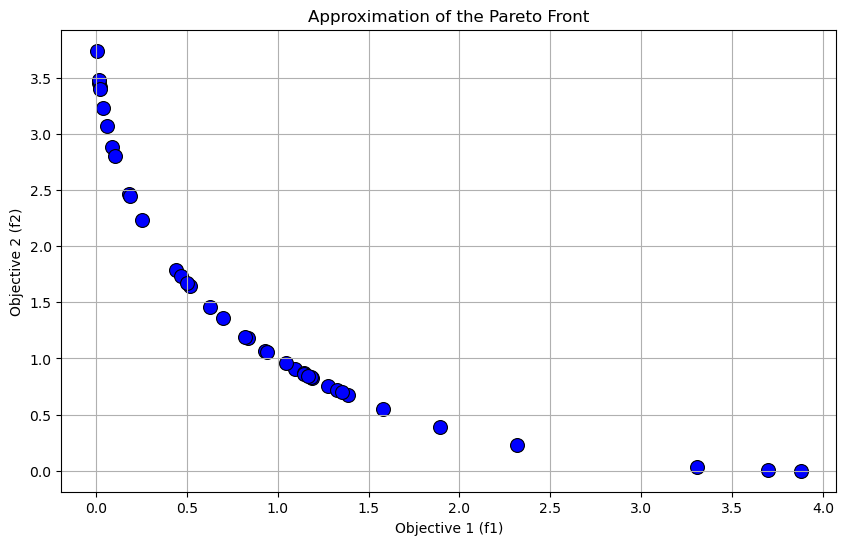

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Run the AMOSA code above to generate the final archive
# Assuming archive contains solutions at the end of the AMOSA algorithm

# Extract objective values for each solution in the archive
archive_objectives = [(objective1(sol), objective2(sol)) for sol in archive]
f1_values = [obj[0] for obj in archive_objectives]
f2_values = [obj[1] for obj in archive_objectives]

# Create a scatter plot of the objective values to approximate the Pareto front
plt.figure(figsize=(10, 6))
sns.scatterplot(x=f1_values, y=f2_values, s=100, color="blue", edgecolor="k")
plt.title("Approximation of the Pareto Front")
plt.xlabel("Objective 1 (f1)")
plt.ylabel("Objective 2 (f2)")
plt.grid(True)
plt.show()


# Genetic Algorithm (GA)

A **Genetic Algorithm (GA)** is a metaheuristic inspired by the process of natural selection. It is used for optimization and search problems and relies on bio-inspired operators like mutation, crossover, and selection.

## Basic GA Process

The GA process iteratively evolves a population of candidate solutions (called individuals or phenotypes) to approach optimal solutions. Each candidate solution is represented by its **genotype** or **chromosome**, which can be altered over generations through mutation and crossover.

The main steps in GA are as follows:
1. **Initialization**: Start with a randomly generated population.
2. **Fitness Evaluation**: Evaluate each individual's fitness based on the objective function.
3. **Selection**: Select fitter individuals to form a new generation.
4. **Recombination (Crossover)**: Combine selected individuals to form offspring.
5. **Mutation**: Introduce random alterations in offspring chromosomes.
6. **Termination**: Stop when the population achieves a satisfactory fitness or reaches a maximum number of generations.

## Key Operations in GA

1. **Chromosome Representation**:
   - Each chromosome (or individual) represents a solution and is made up of **genes**.
   - Genes can be represented in different ways, such as binary (0 and 1), floating-point numbers, integers, or symbols.

2. **Fitness Function**:
   - The fitness function evaluates how good a solution (chromosome) is with respect to the optimization objective.

3. **Genetic Operators**:
   - **Selection**: Choose individuals based on fitness to create offspring.
   - **Crossover**: Combine two parent chromosomes to create offspring.
   - **Mutation**: Randomly alter genes to maintain diversity in the population.

## Chromosome Encoding Example

In **binary encoding**, each solution is represented as a string of bits, where each bit sequence represents different **genes** or characters required for the solution.

For example, the following table represents a mapping of four-bit genes for encoding numbers and operators:

$$
\begin{array}{|c|c|}
\hline
\text{Character} & \text{Binary Representation} \\
\hline
0 & 0000 \\
1 & 0001 \\
2 & 0010 \\
3 & 0011 \\
4 & 0100 \\
5 & 0101 \\
6 & 0110 \\
7 & 0111 \\
8 & 1000 \\
9 & 1001 \\
+ & 1010 \\
- & 1011 \\
* & 1100 \\
/ & 1101 \\
\hline
\end{array}
$$

### Example Chromosome
The expression $7 + 6 * 4 / 2 + 1$ would be represented as follows in binary:

$$
\text{Chromosome} = 0111\ 1010\ 0110\ 1100\ 0100\ 1101\ 0010\ 1010\ 0001
$$

This binary string of genes encodes each character in the expression.

## GA Flow Chart

The GA flow chart for solving optimization problems can be summarized as:

1. **Initialize Population**
2. **Evaluate Fitness**
3. **Selection**
4. **Crossover**
5. **Mutation**
6. **New Population**

The process is repeated until the population reaches an optimal solution or a predefined number of generations.

---

GAs provide a robust method to search for solutions by mimicking natural selection, evolving a population of solutions over time. They are used widely in optimization, machine learning, and AI applications.


# Genetic Algorithm Concepts

The **Genetic Algorithm (GA)** is an optimization algorithm inspired by natural selection principles to evolve solutions over generations. This involves genetic operators such as mutation, crossover, and selection.

## Chromosomes and Genes

A chromosome represents a solution as a series of genes. For instance:

$$
\text{Chromosome} = 0111\ 1010\ 0110\ 1100\ 0100\ 1101\ 0010\ 1010\ 0001
$$

Random arrangements may sometimes produce nonsensical strings, such as:

$$
\text{Random Bit String} = 0010\ 0010\ 1010\ 1110\ 1011\ 0111\ 0010
$$

decoded as: $2\ 2\ +\ \text{N/A}\ -\ 7\ 2$.

## Fitness Function and Selection

The **fitness function** evaluates each individual's performance to guide the GA toward better solutions.

### Weighted-Sum Fitness Calculation

For multi-objective problems, **fitness** can be calculated as:

$$
\text{Fitness} = \sum_i w_i \cdot f_i(x)
$$

where $ w_i \in (0, 1) $ and $ \sum w_i = 1 $. These weights are encoded to promote diversity through **phenotypic fitness sharing**.

### Selection Strategy

An **elitist selection** strategy is often used:
1. Sort population by fitness.
2. Directly select the top $1/10$ individuals.
3. Select the remaining $9/10$ by random competition.

## Crossover and Mutation

### Crossover

**Crossover** is recombination where genes are exchanged between chromosomes. Given two chromosomes:

$$
\text{Parent 1} = 1000\ 1001\ 1100\ 0010\ 1010
$$
$$
\text{Parent 2} = 0101\ 0001\ 1010\ 0001\ 0111
$$

Choosing a random crossover point (e.g., position 9), we swap bits after this point, resulting in offspring:

$$
\text{Offspring 1} = 1000\ 1001\ 1010\ 0001\ 0111
$$
$$
\text{Offspring 2} = 0101\ 0001\ 1100\ 0010\ 1010
$$

#### Adaptive Crossover Probability

The crossover probability $ P_{ci} $ adapts based on fitness:

$$
P_{ci} = 
\begin{cases} 
P_c \cdot \frac{r_i}{r_{\text{max}}}, & \text{if } r_i < r_{\text{avg}} \\ 
P_c, & \text{if } r_i \geq r_{\text{avg}} 
\end{cases}
$$

where $ P_c $ is the base probability, $ r_i $ is individual fitness, $ r_{\text{max}} $ is the maximum fitness, and $ r_{\text{avg}} $ is the average fitness.

### Mutation

**Mutation** introduces random gene changes to maintain genetic diversity. Mutation probability $ P_{mi} $ is adjusted as:

$$
P_{mi} = 
\begin{cases} 
P_m \cdot \frac{r_i}{r_{\text{max}}}, & \text{if } r_i < r_{\text{avg}} \\ 
P_m, & \text{if } r_i \geq r_{\text{avg}} 
\end{cases}
$$

#### Adaptive Mutation Rate

The mutation rate $ P_m $ depends on population diversity:

$$
P_m = P_{m0} \left[ 1 - \frac{2(r_{\text{max}} - r_{\text{min}})}{3(\text{PopSize} - 1)} \right]
$$

where $ r_{\text{max}} $ and $ r_{\text{min}} $ are the maximum and minimum fitness values, and 4 \text{PopSize} $ is the population size.

## Key Takeaways

1. **Fitness-Dependent Adaptation**:
   - Higher fitness individuals use lower crossover and mutation rates to protect good genes.
   - Lower fitness individuals are given higher rates to increase diversity.

2. **Avoiding Premature Convergence**:
   - Adaptive rates prevent dominant genes from taking over too soon, allowing more exploration in early stages of evolution.


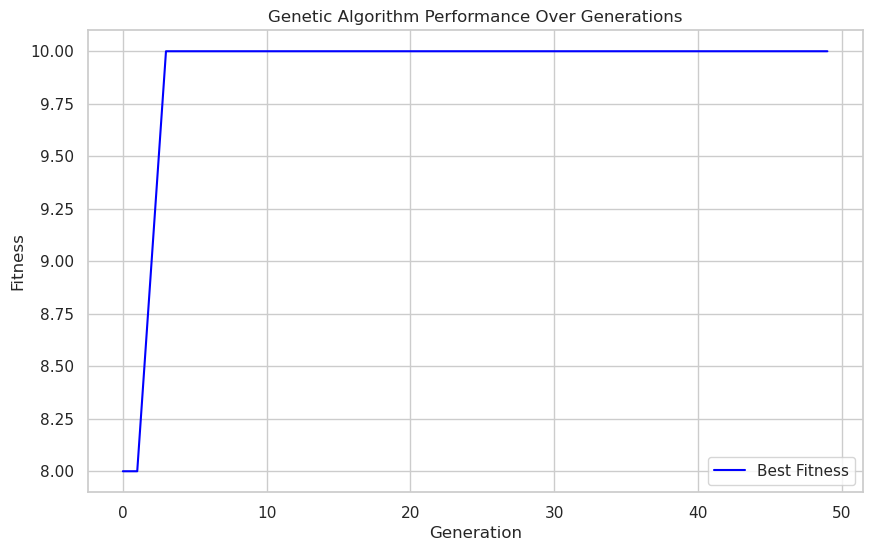

In [4]:
import random
import seaborn as sns
import matplotlib.pyplot as plt

# Genetic Algorithm Parameters
POP_SIZE = 20            # Number of individuals in population
GENE_LENGTH = 10         # Length of each chromosome (number of genes)
MAX_GENERATIONS = 50     # Number of generations to run
CROSSOVER_RATE = 0.7     # Probability of crossover
MUTATION_RATE = 0.01     # Probability of mutation

# Generate a random chromosome with binary genes (0 or 1)
def generate_chromosome():
    return [random.randint(0, 1) for _ in range(GENE_LENGTH)]

# Fitness function: sum of genes in the chromosome
def fitness_function(chromosome):
    return sum(chromosome)

# Selection: Selects individuals based on fitness proportionate selection (roulette wheel)
def select(population):
    max_fitness = sum(fitness_function(individual) for individual in population)
    pick = random.uniform(0, max_fitness)
    current = 0
    for individual in population:
        current += fitness_function(individual)
        if current > pick:
            return individual

# Crossover operation: Single-point crossover
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        point = random.randint(1, GENE_LENGTH - 1)
        return parent1[:point] + parent2[point:], parent2[:point] + parent1[point:]
    return parent1, parent2

# Mutation operation: Flips each gene with a certain probability
def mutate(chromosome):
    return [1 - gene if random.random() < MUTATION_RATE else gene for gene in chromosome]

# Genetic Algorithm main loop
def genetic_algorithm():
    population = [generate_chromosome() for _ in range(POP_SIZE)]
    best_fitnesses = []

    for generation in range(MAX_GENERATIONS):
        # Evaluate fitness of each individual
        fitness_values = [fitness_function(individual) for individual in population]
        best_fitnesses.append(max(fitness_values))

        # Create next generation
        new_population = []
        for _ in range(POP_SIZE // 2):
            parent1 = select(population)
            parent2 = select(population)
            offspring1, offspring2 = crossover(parent1, parent2)
            new_population.extend([mutate(offspring1), mutate(offspring2)])

        population = new_population

    return best_fitnesses

# Run the genetic algorithm and plot results
best_fitnesses = genetic_algorithm()

# Plotting with Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(MAX_GENERATIONS), y=best_fitnesses, color="blue", label="Best Fitness")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Genetic Algorithm Performance Over Generations")
plt.legend()
plt.show()


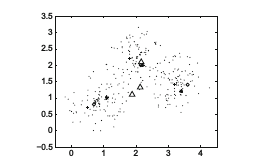

Fig.3 Illustration of degeneracy due to crossover (from [16]). Here, asterisk denotes three cluster centers (1.1, 1.0), (2.2, 2.0), (3.4, 1.2) for chromosome m1 , + denotes three cluster centers (3.2, 1.4), (1.8, 2.2), (0.5, 0.7) for the chromosome m2 , open triangle denotes the chromosome obtained by crossing m1 and m2 , and open circle denotes the chromosome obtained by crossing m1 and m2 with three cluster centers (0.5, 0.7), (1.8, 2.2), (3.2, 1.4)

### 2 Genetic Algorithm with Gene Rearrangement

Genetic clustering algorithms have a certain degree of degeneracy in the evolution process. The degeneracy problem is mainly caused by the non-one-to-one correspondence between the solution space of the clustering problem and the genetic individual coding in the evolution process. The degeneracy of the evolutionary process usually causes the algorithm to search the local solution space repeatedly. Therefore, the search efficiency of the genetic clustering algorithm can be improved by avoiding the degeneracy of the evolution process.

To illustrate how the degeneracy occurs, consider a clustering problem in which a set of patterns is grouped into $ K $ clusters so that patterns in the same cluster are similar and differentiate from those of other clusters in some sense. Denote two chromosomes as:

$$
x = [x_{11}, \dots, x_{1N}, \dots, x_{K1}, \dots, x_{KN}] = [x_1, \dots, x_K]
$$
$$
y = [y_{11}, \dots, y_{1N}, \dots, y_{K1}, \dots, y_{KN}] = [y_1, \dots, y_K]
$$

where $ x_i = [x_{i1}, \dots, x_{iN}] \in \mathbb{R}^{1 \times N} $ and $ y_i = [y_{i1}, \dots, y_{iN}] \in \mathbb{R}^{1 \times N} $, and $ x $ is called a referenced vector. Let $ P_1 = \{1, \dots, K\} $ be a set of indexes of $ \{x_1, \dots, x_K\} $ and $ P_2 = \emptyset $.

Consider the rearrangement of $ P_1 $ to $ P_2 $:

$$
\text{for } i = 1 \text{ to } K \text{ do} \quad k = \arg \min_{j \in P_1, j \notin P_2} \| y_i - x_j \|^2
$$
$$
P_1 = P_1 \setminus \{k\} \quad \text{and} \quad P_2(i) = k
$$

Then, the elements of $ P_2 $ will be a permutation of those of $ P_1 $, and $ y $ will be rearranged according to $ P_2 $, i.e.,

$$
y_k = y_{P_2(k)}
$$

**Gene Rearrangement**:

If $ x $ and $ y $ are two chromosomes in gene representation, and the elements of $ y $ are rearranged according to the indexes in $ P_2 $ to get a new vector whose elements are given by:

$$
\tilde{y}_i = y_{P_2(i)}, \quad i = 1, \dots, N
$$

then the new chromosome $ \tilde{y} = [\tilde{y}_i]_{i=1}^{N} = [y_{P_2(i)}]_{i=1}^N $ is called the gene rearrangement of the original chromosome $ y $.

**Genetic Algorithm with Gene Rearrangement (GAGR)**:

The genetic algorithm with gene rearrangement (GAGR) clustering algorithm is given in **Algorithm 9.7**.

1. **Initialization**:
   - Generate a group of cluster centers with size \( NP \).
   - Consider only valid chromosomes (that have at least one data point in each cluster).
   - Each data point of the set is assigned to the cluster with the closest cluster center using the Euclidean distance.

2. **Evaluate each chromosome** and copy the best chromosome $ p_{\text{best}} $ of the initial population in a separate location.

3. If the termination condition is not reached, go to Step 4; else select the best individual from the population as the best cluster result.

4. **Select individuals** from the population for crossover and mutation.

5. Apply crossover operator to the selected individuals based on the crossover probability.

6. Apply mutation operator to the selected individuals based on the mutation probability.

7. **Evaluate the newly generated candidates.**

8. Compare the worst chromosome in the new population with $ p_{\text{best}} $ in terms of their fitness values. If the former is worse than the latter, replace it by $ p_{\text{best}} $.

9. Find the best chromosome in the new population and replace $ p_{\text{best}} $.

10. For the new population, select the best chromosome as a reference, which other chromosomes might fall into the gene rearrangement if needed.

11. **Go back to Step 3**.

**Chromosome Representation**:

Extensive experiments comparing real-valued and binary GAs indicate that the real-valued GA is more efficient in terms of CPU time. In real-valued gene representation, each chromosome constitutes a sequence of cluster centers, i.e., each chromosome is described by $ M = N \cdot K $ real-valued numbers as follows:

$$
m = [m_{11}, \dots, m_{1N}, \dots, m_{K1}, \dots, m_{KN}] = [m_1, \dots, m_K]
$$

where $ N $ is the dimension of the feature space and $ K $ is the number of clusters; the first $ N $ elements denote the first cluster center, the following $ N $ elements denote the second cluster center, and so forth.

**Fitness Function**:

The fitness function is used to define a fitness value to each candidate solution. A common clustering criterion or quality indicator is the sum of squared error (SSE) measure, defined as:

$$
SSE = \sum_{x \in C_i} \| x - m_i \|^2
$$

where $ x \in C_i $ is a data point assigned to that cluster. This measure computes the cumulative distance of each pattern from its cluster center of each cluster individually, and then sums those measures over all clusters. If this measure is small, then the distances from patterns to cluster centers are all small and the clustering would be regarded favorably.

The fitness function of the chromosome is defined as the inverse of SSE:

$$
f = \frac{1}{SSE}
$$

This fitness function will be maximized during the evolutionary process and lead to minimization of the SSE.

**Evolutionary Operators**:

- **Crossover**:
  Let $ x $ and $ y $ be two chromosomes to be crossed, then the heuristic crossover is given by:

  $$
  x' = x + r(x - y)
  $$
  $$
  y' = x
  $$

  where $ r = U(0, 1) $ with $ U(0, 1) $ being a uniform distribution on the interval $[0, 1]$ and $ x $ is assumed to be better than $ y $ in terms of the fitness.

- **Mutation**:
  Let $ f_{\text{min}} $ and $ f_{\text{max}} $ be the minimum and maximum fitness values in the current population, respectively. For an individual with fitness value $ f $, a number $ \delta \in [-R, +R] $ is generated with uniform distribution, where $ R $ is given by:

  $$
  R = \begin{cases}
  \frac{f - f_{\text{min}}}{f_{\text{max}} - f_{\text{min}}}, & \text{if } f_{\text{max}} > f \\
  1, & \text{if } f_{\text{max}} = f
  \end{cases}
  $$

  If the minimum and maximum values of the dataset along the $ i $-th dimension ($ i = 1, \dots, N $) are $ m_{\text{min}} $ and $ m_{\text{max}} $, respectively, then after mutation the $ i $-th element of the individual is given by:

  $$
  m_i = 
  \begin{cases}
  m_i + \delta \cdot (m_{\text{max}} - m_i), & \text{if } \delta \geq 0 \\
  m_i + \delta \cdot (m_i - m_{\text{min}}), & \text{otherwise}
  \end{cases}
  $$

One key feature of gene rearrangement is to avoid the degeneracy resulting from the representations used in many clustering problems. The degeneracy mainly arises from a non-one-to-one correspondence between the representation and the clustering result. 


<!DOCTYPE html>
<html lang="en">
<head>
  <meta charset="UTF-8">
  <meta name="viewport" content="width=device-width, initial-scale=1.0">
  <title>Genetic Algorithm with Gene Rearrangement</title>
  <script src="https://cdn.jsdelivr.net/npm/graphlib@2.1.0/dist/graphlib.min.js"></script>
  <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
  <style>
    #graph-container {
      width: 500px;
      height: 500px;
      border: 1px solid black;
    }
  </style>
</head>
<body>
  <h1>Genetic Algorithm with Gene Rearrangement</h1>

  <div id="graph-container"></div>
  <canvas id="fitness-chart" width="400" height="200"></canvas>

  <script>
    // Step 1: Randomly generate initial population (2D cluster centers)
    function generateRandomCenters(numClusters, numDimensions) {
      let centers = [];
      for (let i = 0; i < numClusters; i++) {
        let center = [];
        for (let j = 0; j < numDimensions; j++) {
          center.push(Math.random() * 100); // random values between 0 and 100
        }
        centers.push(center);
      }
      return centers;
    }

    // Step 2: Fitness function (SSE for clustering)
    function fitnessFunction(centers, dataPoints) {
      let sse = 0;
      for (let point of dataPoints) {
        let minDist = Infinity;
        for (let center of centers) {
          let dist = Math.sqrt(center.reduce((sum, val, idx) => sum + Math.pow(val - point[idx], 2), 0));
          minDist = Math.min(minDist, dist);
        }
        sse += Math.pow(minDist, 2);
      }
      return sse;
    }

    // Step 3: Crossover operation
    function crossover(parent1, parent2) {
      const crossoverPoint = Math.floor(Math.random() * parent1.length);
      return [
        ...parent1.slice(0, crossoverPoint), 
        ...parent2.slice(crossoverPoint)
      ];
    }

    // Step 4: Mutation operation
    function mutate(center) {
      const mutationIdx = Math.floor(Math.random() * center.length);
      center[mutationIdx] = Math.random() * 100; // Random mutation
    }

    // Step 5: Gene rearrangement
    function rearrangeGenes(centers, dataPoints) {
      // Placeholder function for rearrangement logic.
      // This should aim to avoid degeneracy in the evolution process.
      return centers;
    }

    // Step 6: Genetic Algorithm
    function geneticAlgorithm(dataPoints, numClusters, populationSize, numGenerations) {
      let population = [];
      for (let i = 0; i < populationSize; i++) {
        population.push(generateRandomCenters(numClusters, 2)); // 2D centers
      }

      let fitnessHistory = [];

      for (let generation = 0; generation < numGenerations; generation++) {
        population.sort((a, b) => fitnessFunction(a, dataPoints) - fitnessFunction(b, dataPoints));

        let nextGeneration = population.slice(0, populationSize / 2); // Select the top half

        while (nextGeneration.length < populationSize) {
          let parent1 = nextGeneration[Math.floor(Math.random() * nextGeneration.length)];
          let parent2 = nextGeneration[Math.floor(Math.random() * nextGeneration.length)];
          let child = crossover(parent1, parent2);
          mutate(child);
          nextGeneration.push(child);
        }

        population = rearrangeGenes(nextGeneration, dataPoints);
        fitnessHistory.push(fitnessFunction(population[0], dataPoints)); // Store fitness history for graphing
      }

      return { bestCenters: population[0], fitnessHistory };
    }

    // Step 7: Visualize with GraphJS
    function drawGraph(dataPoints, bestCenters) {
      const graph = new GraphJS.Graph();
      
      // Draw data points
      dataPoints.forEach((point, idx) => {
        graph.addNode(`dataPoint-${idx}`, { x: point[0], y: point[1], label: `Point ${idx}` });
      });

      // Draw centers
      bestCenters.forEach((center, idx) => {
        graph.addNode(`center-${idx}`, { x: center[0], y: center[1], label: `Center ${idx}` });
      });

      const container = document.getElementById('graph-container');
      const renderer = new GraphJS.Renderer(container);
      renderer.render(graph);
    }

    // Step 8: Plot fitness graph using Chart.js
    function plotFitnessGraph(fitnessHistory) {
      const ctx = document.getElementById('fitness-chart').getContext('2d');
      new Chart(ctx, {
        type: 'line',
        data: {
          labels: fitnessHistory.map((_, idx) => idx + 1),
          datasets: [{
            label: 'Fitness (SSE)',
            data: fitnessHistory,
            borderColor: 'rgba(75, 192, 192, 1)',
            fill: false,
          }],
        },
      });
    }

    // Example: Running Genetic Algorithm with random data
    const dataPoints = Array.from({ length: 50 }, () => [Math.random() * 100, Math.random() * 100]);
    const numClusters = 3;
    const populationSize = 10;
    const numGenerations = 100;

    const { bestCenters, fitnessHistory } = geneticAlgorithm(dataPoints, numClusters, populationSize, numGenerations);
    
    // Visualize the results
    drawGraph(dataPoints, bestCenters);
    plotFitnessGraph(fitnessHistory);
  </script>
</body>
</html>


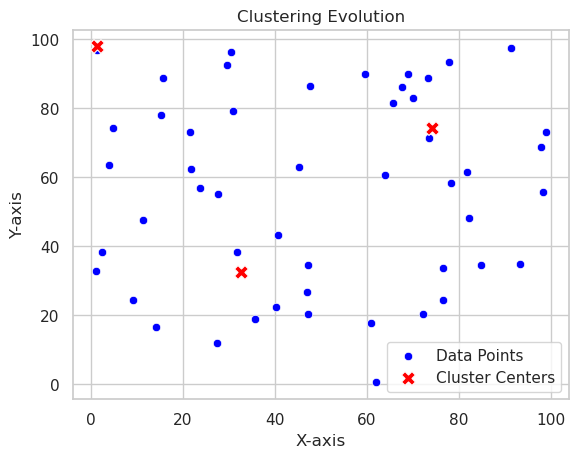

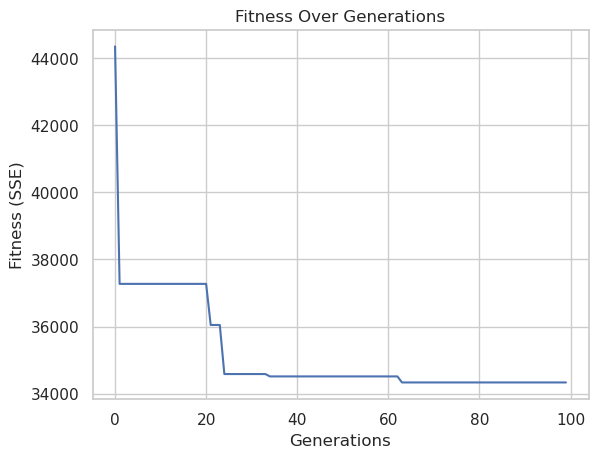

In [10]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

# Step 1: Randomly generate initial population (2D cluster centers)
def generate_random_centers(num_clusters, num_dimensions):
    centers = []
    for _ in range(num_clusters):
        center = np.random.rand(num_dimensions) * 100  # random values between 0 and 100
        centers.append(center)
    return np.array(centers)

# Step 2: Fitness function (Sum of Squared Errors for clustering)
def fitness_function(centers, data_points):
    sse = 0
    for point in data_points:
        # Calculate the distance from each point to its closest center
        distances = np.linalg.norm(centers - point, axis=1)
        sse += np.min(distances) ** 2
    return sse

# Step 3: Crossover operation
def crossover(parent1, parent2):
    crossover_point = np.random.randint(1, parent1.shape[0])
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

# Step 4: Mutation operation
def mutate(center):
    mutation_idx = np.random.randint(len(center))
    center[mutation_idx] = np.random.rand() * 100  # Random mutation
    return center

# Step 5: Gene rearrangement (for preventing degeneracy)
def rearrange_genes(centers, data_points):
    # Here, the gene rearrangement logic can be more complex, but for simplicity:
    return centers

# Step 6: Genetic Algorithm
def genetic_algorithm(data_points, num_clusters, population_size, num_generations):
    population = [generate_random_centers(num_clusters, data_points.shape[1]) for _ in range(population_size)]
    fitness_history = []

    for generation in range(num_generations):
        # Sort the population based on fitness (lower SSE is better)
        population.sort(key=lambda centers: fitness_function(centers, data_points))

        # Keep the top half of the population
        next_generation = population[:population_size // 2]

        # Generate new individuals by crossover and mutation
        while len(next_generation) < population_size:
            # Select two parents randomly from the next_generation (now a list of 2D arrays)
            parent1, parent2 = random.sample(next_generation, 2)  # Use random.sample instead of np.random.choice
            child = crossover(parent1, parent2)
            child = mutate(child)
            next_generation.append(child)

        # Apply gene rearrangement
        population = rearrange_genes(next_generation, data_points)
        fitness_history.append(fitness_function(population[0], data_points))  # Store fitness for plotting

    return population[0], fitness_history

# Step 7: Visualize with Seaborn
def plot_clusters(data_points, cluster_centers):
    # Scatter plot of data points
    sns.scatterplot(x=data_points[:, 0], y=data_points[:, 1], color='blue', label='Data Points')

    # Plot the final cluster centers
    sns.scatterplot(x=cluster_centers[:, 0], y=cluster_centers[:, 1], color='red', marker='X', s=100, label='Cluster Centers')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Clustering Evolution')
    plt.legend()
    plt.show()

def plot_fitness(fitness_history):
    plt.plot(fitness_history)
    plt.xlabel('Generations')
    plt.ylabel('Fitness (SSE)')
    plt.title('Fitness Over Generations')
    plt.show()

# Step 8: Running the Genetic Algorithm
# Generate some random data points for clustering
data_points = np.random.rand(50, 2) * 100  # 50 points in 2D space

# Parameters
num_clusters = 3
population_size = 10
num_generations = 100

# Run the algorithm
best_centers, fitness_history = genetic_algorithm(data_points, num_clusters, population_size, num_generations)

# Plot the results
plot_clusters(data_points, best_centers)
plot_fitness(fitness_history)


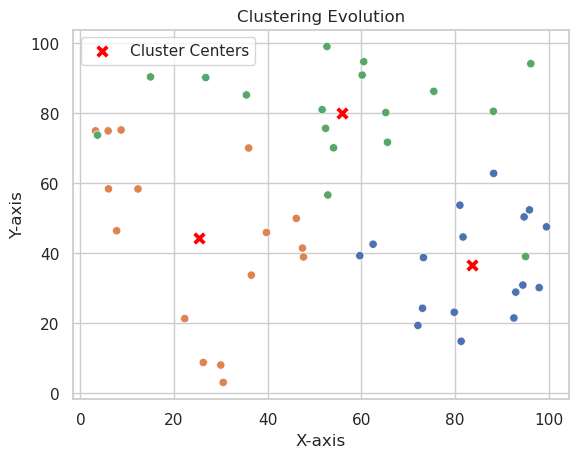

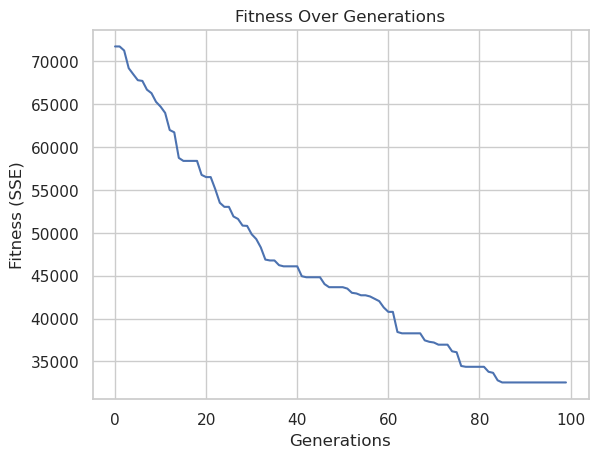

In [21]:
import random
import math
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Randomly generate initial population (assignments of data points to clusters)
def generate_random_assignments(num_points, num_clusters):
    return [random.randint(0, num_clusters - 1) for _ in range(num_points)]

# Step 2: Fitness function (Sum of Squared Errors for clustering)
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

def fitness_function(assignments, data_points, cluster_centers):
    sse = 0
    for i, point in enumerate(data_points):
        cluster_idx = assignments[i]
        center = cluster_centers[cluster_idx]
        sse += euclidean_distance(point, center) ** 2
    return sse

# Step 3: Crossover operation (single-point crossover on assignments)
def crossover(parent1, parent2):
    # Random crossover point
    crossover_point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# Step 4: Mutation operation (reassign a random data point to a random cluster)
def mutate(assignments, num_clusters):
    mutation_idx = random.randint(0, len(assignments) - 1)
    assignments[mutation_idx] = random.randint(0, num_clusters - 1)
    return assignments

# Step 5: Generate new cluster centers based on the current assignments
def generate_cluster_centers(assignments, data_points, num_clusters):
    cluster_centers = []
    for i in range(num_clusters):
        points_in_cluster = [data_points[j] for j in range(len(data_points)) if assignments[j] == i]
        if points_in_cluster:
            center = [sum(coord) / len(points_in_cluster) for coord in zip(*points_in_cluster)]
            cluster_centers.append(center)
        else:
            cluster_centers.append([random.uniform(0, 100) for _ in range(len(data_points[0]))])
    return cluster_centers

# Step 6: Genetic Algorithm for Clustering
def genetic_algorithm(data_points, num_clusters, population_size, num_generations):
    num_points = len(data_points)
    population = [generate_random_assignments(num_points, num_clusters) for _ in range(population_size)]
    fitness_history = []

    # Initial random cluster centers
    cluster_centers = generate_cluster_centers(population[0], data_points, num_clusters)

    for generation in range(num_generations):
        # Calculate fitness for each individual
        fitness_values = [fitness_function(assignments, data_points, cluster_centers) for assignments in population]
        
        # Sort population by fitness (lower is better)
        sorted_population = [x for _, x in sorted(zip(fitness_values, population))]
        
        # Keep the top half of the population
        next_generation = sorted_population[:population_size // 2]

        # Create the next generation via crossover and mutation
        while len(next_generation) < population_size:
            parent1, parent2 = random.sample(next_generation, 2)
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1, num_clusters)
            child2 = mutate(child2, num_clusters)
            next_generation.extend([child1, child2])

        # Update the population
        population = next_generation

        # Generate new cluster centers based on the current best assignments
        cluster_centers = generate_cluster_centers(population[0], data_points, num_clusters)

        # Store the fitness of the best individual
        fitness_history.append(fitness_values[fitness_values.index(min(fitness_values))])

    return population[0], fitness_history, cluster_centers

# Step 7: Visualize with Seaborn
def plot_clusters(data_points, cluster_centers, assignments):
    # Scatter plot of data points
    sns.scatterplot(x=[point[0] for point in data_points], y=[point[1] for point in data_points], hue=assignments, palette="deep", legend=None)

    # Plot the final cluster centers
    sns.scatterplot(x=[center[0] for center in cluster_centers], y=[center[1] for center in cluster_centers], color='red', marker='X', s=100, label='Cluster Centers')
    
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Clustering Evolution')
    plt.legend()
    plt.show()

def plot_fitness(fitness_history):
    plt.plot(fitness_history)
    plt.xlabel('Generations')
    plt.ylabel('Fitness (SSE)')
    plt.title('Fitness Over Generations')
    plt.show()

# Step 8: Running the Genetic Algorithm
# Generate some random data points for clustering
data_points = [[random.uniform(0, 100), random.uniform(0, 100)] for _ in range(50)]  # 50 points in 2D space

# Parameters
num_clusters = 3
population_size = 10
num_generations = 100

# Run the algorithm
best_assignments, fitness_history, best_centers = genetic_algorithm(data_points, num_clusters, population_size, num_generations)

# Plot the results
plot_clusters(data_points, best_centers, best_assignments)
plot_fitness(fitness_history)


## Nondominated Multiobjective Genetic Algorithms (MOGA)

In generation-based evolutionary algorithms (EAs) or genetic algorithms (GAs), the selected individuals are recombined (e.g., crossover) and mutated to constitute the new population. However, some designers/users prefer an **incremental, steady-state population update**, where only one or two individuals are selected and possibly deleted from the current population. These individuals are then replaced by newly recombined and mutated individuals.

### Key Points:

- **Selection**: The process of selecting individuals plays a key role in generation-based EAs or GAs. It is crucial for the success of the algorithm because it determines which individuals are retained and bred for the next generation.
  
- **Steady-State Update**: Unlike traditional generation-based updates, a steady-state update selects one or two individuals and adds the newly recombined and mutated ones.

---

## Fitness Functions

In genetic programming and genetic algorithms, each design solution is represented as a string of numbers, referred to as a **chromosome**. After each round of testing or simulation, the designer's goal is to delete the *n* worst design solutions and breed *n* new ones from the best design solutions. To do this, each design solution is evaluated by a **fitness function**, which helps measure the merit of each solution.

- **Fitness Function**: A fitness function is essentially an objective function used in GAs to guide simulations toward optimal design solutions. It determines how **close** a given solution is to meeting the desired specifications.

- **Pareto Dominance**: A solution $ x_1 \in X$ is said to **Pareto dominate** another solution $ x_2 \in X $ if:
  $$
  f_i(x_1) \leq f_i(x_2) \, \text{for all} \, i \in \{1, 2, \dots, k\} \quad \text{and} \quad f_j(x_1) < f_j(x_2) \, \text{for at least one} \, j
  $$
  where $ f_i(x) $ is the fitness value for objective function $ i $.

- **Survival of the Fittest**: The genetic algorithm (GA) uses fitness to simulate the natural selection process where individuals with higher fitness values are more likely to survive and reproduce, thus guiding the population toward optimal solutions.

- **Challenges with Fitness Functions**:
  - **Early-stage dominance**: Some supernormal individuals may dominate the population early in the process, affecting the global optimization.
  - **Convergence**: Towards the later stages, if the algorithm converges, the potential for further optimization is reduced, and the population may reach a local optimum.

---

## Fitness Selection Schemes

### 1. **Standard Selection Schemes**
Standard selection schemes focus on selecting individuals with higher fitness values. Some popular schemes are:

- **Linear Proportionate Selection**: The probability of selecting an individual is linearly dependent on its fitness.
- **Truncation Selection**: Only the top individuals are selected for reproduction, and they are often selected with multiplicity to maintain a fixed population size.
- **Ranking Selection**: Individuals are ranked based on fitness, and the selection probability is a function of their rank.
- **Tournament Selection**: A random subset of individuals is chosen, and the best individual from this subset is selected for reproduction.

### 2. **Fitness Uniform Selection Scheme (FUSS)**

FUSS aims to preserve genetic diversity by creating suitable selection pressure without focusing solely on maximizing fitness. It involves the following steps:
1. **Random Fitness Selection**: A fitness value $ f $ is randomly selected from the range $[f_{\text{min}}, f_{\text{max}}]$.
2. **Individual Selection**: An individual is selected based on the fitness value nearest to $ f $.

This process helps in preserving diversity in the population and avoids the premature convergence to a local optimum.

---

## Distance Between Individuals

The **distance** $ d(i, j) $ between two individuals $ i $ and $ j $ is defined as:
$$
d(i, j) = |f(i) - f(j)|
$$
where $ f(i) $ and $ f(j) $ are the fitness values of individuals $ i $ and $ j $, respectively.

If $ d(i, j) $ is small, it indicates that the two individuals have similar fitness values, while a large $ d(i, j) $ indicates dissimilar fitness values.

### **Fitness Uniform Deletion Scheme (FUDS)**

FUDS aims to govern different parts of the solution space by deleting individuals with commonly occurring fitness values, thus preserving diversity in the population. This method helps avoid setting a fixed selection intensity parameter, addressing the issue of premature convergence.

---

## Goldberg’s Non-Inferior Sorting Method

In multiobjective genetic algorithms, **non-inferior sorting** is a technique used to select the best individuals based on the **Pareto dominance** concept. An individual $ x_i(t) $ in the population of the $ t $-th generation is associated with a number $ r_i(t) $, which indicates how many individuals dominate it.

Individuals with lower $ r_i(t) $ values are considered superior because they are closer to the **Pareto front**.

The goal of the evolutionary process is to move the entire population towards the **Pareto boundary**, which consists of non-dominated solutions.

---

### Summary

- **Selection and Fitness**: The fitness function guides the evolution of the population by selecting individuals based on their fitness. However, improper selection or fitness functions can cause issues such as premature convergence or deceptive individuals.
  
- **Diversity Preservation**: Methods like **Fitness Uniform Selection Scheme (FUSS)** and **Fitness Uniform Deletion Scheme (FUDS)** aim to preserve genetic diversity and avoid the algorithm converging too early.

- **Pareto Dominance**: In multiobjective optimization, solutions are compared based on **Pareto dominance**, and the goal is to find a set of solutions that form the **Pareto front**.


In [25]:
import random
import math

# Objective Functions (Multiobjective Problem Example)
def objective_1(x):
    return x[0] ** 2 + x[1] ** 2  # Example objective 1 (minimization)

def objective_2(x):
    return (x[0] - 1) ** 2 + (x[1] - 1) ** 2  # Example objective 2 (minimization)

# Fitness Function: Nondominated Sorting
def dominates(x, y):
    """Check if solution x dominates solution y (Pareto Dominance)"""
    return all(x[i] <= y[i] for i in range(len(x))) and any(x[i] < y[i] for i in range(len(x)))

def non_dominated_sort(population):
    """Non-dominated sorting of a population"""
    front = [[]]
    for p in population:
        p['domination_count'] = 0
        p['dominated_solutions'] = []
        for q in population:
            if dominates(p['objectives'], q['objectives']):
                p['dominated_solutions'].append(q)
            elif dominates(q['objectives'], p['objectives']):
                p['domination_count'] += 1
        if p['domination_count'] == 0:
            front[0].append(p)
    
    i = 0
    while front[i]:
        next_front = []
        for p in front[i]:
            for q in p['dominated_solutions']:
                q['domination_count'] -= 1
                if q['domination_count'] == 0:
                    next_front.append(q)
        i += 1
        front.append(next_front)
    return front[:-1]

def tournament_selection(population, tournament_size=3):
    """Tournament selection based on Pareto Front"""
    # Ensure the tournament size does not exceed population size
    tournament_size = min(tournament_size, len(population))
    
    # Randomly select the tournament participants
    tournament = random.sample(population, tournament_size)
    
    # Perform non-dominated sorting on the selected individuals
    fronts = non_dominated_sort(tournament)
    
    # Check if there are any valid Pareto fronts
    if not fronts or len(fronts[0]) == 0:
        # If no Pareto front is found or the front is empty, fall back to random selection
        print("Warning: No valid Pareto front found, resorting to random selection")
        return random.choice(tournament)
    
    # Return a random individual from the Pareto front (ensure the front is not empty)
    front = fronts[0]
    return random.choice(front)



# def tournament_selection(population, tournament_size=3):
#     """Tournament selection based on Pareto Front"""
#     # Ensure the tournament size does not exceed population size
#     tournament_size = min(tournament_size, len(population))
    
#     # Randomly select the tournament participants
#     tournament = random.sample(population, tournament_size)
    
#     # Perform non-dominated sorting on the selected individuals
#     fronts = non_dominated_sort(tournament)
    
#     # Check if there are any valid Pareto fronts
#     if not fronts:
#         raise ValueError("No Pareto fronts found. Population might be too small or invalid.")
    
#     # Return a random individual from the Pareto front (ensure the front is not empty)
#     front = fronts[0]
#     if front:
#         return random.choice(front)
#     else:
#         # If no valid individuals are found, fall back to a random selection
#         return random.choice(tournament)



# Crossover: Simulated Binary Crossover (SBX)
def crossover(parent1, parent2, crossover_rate=0.9):
    """Simulated Binary Crossover"""
    if random.random() > crossover_rate:
        return parent1, parent2  # No crossover

    child1, child2 = parent1.copy(), parent2.copy()
    for i in range(len(parent1)):
        if random.random() > 0.5:
            child1[i] = 0.5 * (parent1[i] + parent2[i])
            child2[i] = 0.5 * (parent1[i] + parent2[i])
    return child1, child2

# Mutation: Polynomial Mutation
def mutate(child, mutation_rate=0.1):
    """Polynomial Mutation"""
    for i in range(len(child)):
        if random.random() < mutation_rate:
            child[i] += random.uniform(-0.1, 0.1)  # Small mutation
    return child

# Main Genetic Algorithm Function
def genetic_algorithm(num_generations, population_size, crossover_rate=0.9, mutation_rate=0.1):
    population = []
    
    # Initialize the population
    for _ in range(population_size):
        individual = {'chromosome': [random.uniform(-5, 5), random.uniform(-5, 5)]}  # Random chromosome
        individual['objectives'] = [objective_1(individual['chromosome']), objective_2(individual['chromosome'])]
        population.append(individual)
    
    # Run the genetic algorithm
    for generation in range(num_generations):
        # Selection: Tournament selection
        selected_parents = [tournament_selection(population) for _ in range(population_size // 2)]
        
        # Crossover and Mutation
        next_population = []
        for i in range(0, len(selected_parents), 2):
            parent1, parent2 = selected_parents[i], selected_parents[i+1]
            child1, child2 = crossover(parent1['chromosome'], parent2['chromosome'], crossover_rate)
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            next_population.append({'chromosome': child1, 'objectives': [objective_1(child1), objective_2(child1)]})
            next_population.append({'chromosome': child2, 'objectives': [objective_1(child2), objective_2(child2)]})
        
        # Combine the parent and offspring populations
        population += next_population
        
        # Perform Non-dominated Sorting to create Pareto Fronts
        fronts = non_dominated_sort(population)
        
        # Keep the best individuals for the next generation
        population = []
        rank = 0
        while len(population) < population_size:
            front = fronts[rank]
            if len(population) + len(front) > population_size:
                break
            population.extend(front)
            rank += 1
        
        # Keep the population size constant by truncating
        population = population[:population_size]
        
        # Print the Pareto front for this generation
        print(f"Generation {generation + 1}:")
        for individual in population:
            print(f"  {individual['objectives']}")
    
    return population

# Example Run
final_population = genetic_algorithm(num_generations=50, population_size=20)

# Extracting the final Pareto front (Objective values of final solutions)
pareto_front = [individual['objectives'] for individual in final_population]

import matplotlib.pyplot as plt

# Plotting the Pareto Front
pareto_front = list(zip(*pareto_front))
plt.scatter(pareto_front[0], pareto_front[1], c='blue')
plt.title("Pareto Front")
plt.xlabel("Objective 1 (x^2 + y^2)")
plt.ylabel("Objective 2 ((x-1)^2 + (y-1)^2)")
plt.show()


Generation 1:
  [0.9622918318533306, 4.973619115090176]
  [2.8085067016202347, 0.612962298577856]
  [2.6074308787688123, 6.706915564697101]
  [2.6074308787688123, 6.706915564697101]
  [2.906671616069797, 0.650363614401831]
  [3.9035285148878733, 5.544259422163812]
  [3.40075912408021, 9.958997588660852]
  [4.467720162443866, 5.4739961609898025]
  [3.4784601370129167, 7.058093750595575]
  [3.9035285148878733, 5.544259422163812]
  [7.598508087941958, 4.596563460181671]
  [7.598508087941958, 4.596563460181671]
  [3.601243694615595, 8.454848737936535]
  [11.411648207599303, 7.6773128763937475]
  [12.730597164973432, 6.985658988060936]
  [10.074585598201352, 7.863734755347457]
  [10.074585598201352, 7.863734755347457]
  [10.074585598201352, 7.863734755347457]
  [11.411648207599303, 7.6773128763937475]
Generation 2:
  [0.9622918318533306, 4.973619115090176]
  [2.8085067016202347, 0.612962298577856]
  [0.9622918318533306, 4.973619115090176]
  [3.6884354525015515, 0.3202954730186304]
  [2.6019

IndexError: Cannot choose from an empty sequence

## Nondominated Sorting Genetic Algorithms

In multi-objective optimization problems, the improvement of one objective often comes at the cost of degrading another objective. Therefore, a unique optimal solution is hard to identify, and instead, we seek a **family of optimal solutions** called the **Pareto-optimal front** or **nondominated set**. A **Multiobjective Evolutionary Algorithm (MOEA)** is a popular approach to solving these problems, as it can find multiple Pareto-optimal solutions in a single run.

### Challenges in Multiobjective Optimization
Unlike single-objective optimization problems, where there is usually a unique optimal solution, in multi-objective problems, multiple solutions lie on or near the **Pareto-optimal front**. An algorithm is considered successful if it generates a large number of alternative solutions that represent this front.

### Vector Evaluated Genetic Algorithm (VEGA)
One of the early practical MOEAs, the **Vector Evaluated Genetic Algorithm (VEGA)**, was developed by Schaffer in 1985. However, VEGA has a bias toward some Pareto-optimal solutions, which can be undesirable for decision-makers who want to explore a diverse set of solutions across the entire Pareto-optimal front.

### Dominating Points
In multi-objective optimization, the number of **dominating points** $d(s, P(t))$ represents the number of points in a set $P(t)$ that dominate a point $s$. It is defined as:

$$
d(s, P(t)) = |\{y \in P(t) \mid y \prec s\}|
$$

This measure favors solutions located in sparsely populated regions of the better fronts. However, when the population consists only of nondominated solutions, this measure may not work as expected.

## Niched Pareto Genetic Algorithm
The **Niched Pareto Genetic Algorithm** (NPGA) combines **tournament selection** with **Pareto dominance**. In tournament selection, two individuals compete, and the winner is chosen based on domination. If both individuals are dominated or nondominated, the winner is determined by **sharing**, where individuals that have fewer individuals in their niche are selected. This ensures the diversity of solutions.

### Sharing Function

The **sharing function value** $ sh(x_i, x_j) $ is used to quantify how similar two individuals $x_i$ and $x_j$ are in terms of their phenotypic distance. It is defined as:

$$
sh(x_i, x_j) =
\begin{cases}
1 - \frac{d(x_i, x_j)^2}{\sigma_{share}^2}, & \text{if } d(x_i, x_j) < \sigma_{share} \\
0, & \text{otherwise}
\end{cases}
$$

Where $ d(x_i, x_j) $ is the Euclidean distance between the individuals $x_i$ and $x_j$, and $ \sigma_{share} $ is the maximum allowed distance for individuals to be considered part of the same niche.

### Niche Count
Given a set of individuals $ X = \{ x_1, x_2, \dots, x_L \} $ (the union of parent and offspring populations), the **niche count** of an individual $x$ is defined as:

$$
nc(x | X, \sigma) = \sum_{i=1}^{L} sh(x, x_i)
$$

The sharing function is used to perform selection based on **degraded fitness values**. These values are obtained by dividing the original fitness by the number of individuals around it in its niche, which promotes diversity.

## Nondominated Sorting Genetic Algorithm (NSGA)
The **Nondominated Sorting Genetic Algorithm (NSGA)** differs from a standard genetic algorithm in how the selection operator works. The key idea is to rank the population based on nondomination before performing selection. 

The steps are as follows:

1. **Input**: Maximum number of generations (`maxgen`).
2. **Initialization**: Initialize the population at generation 0.
3. **Main Loop**:
   - Rank the population by nondomination.
   - Assign a dummy fitness value to each individual.
   - Perform sharing within each front.
   - Continue until all individuals are classified into fronts.
4. **Reproduction**: Using the dummy fitness values, perform crossover and mutation to create the next generation.
5. **Termination**: The algorithm stops when the maximum number of generations is reached.

### Algorithm: Nondominated Sorting Genetic Algorithm (NSGA)



In [29]:
import random
import math

# Helper function to calculate the Euclidean distance between two individuals
def euclidean_distance(ind1, ind2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(ind1, ind2)))

# Helper function for Pareto dominance comparison
def dominates(ind1, ind2):
    better_in_all = False
    better_in_at_least_one = False
    for i in range(len(ind1)):
        if ind1[i] < ind2[i]:
            better_in_all = True
        elif ind1[i] > ind2[i]:
            better_in_at_least_one = True
    return better_in_all and better_in_at_least_one

# Helper function for the sharing function
def sharing_function(distance, sigma_share):
    if distance < sigma_share:
        return 1 - (distance ** 2) / (sigma_share ** 2)
    else:
        return 0

# Nondominated sorting function
def nondominated_sorting(population):
    fronts = []
    
    # Initialize all individuals with required fields
    for p in population:
        p['dominated_count'] = 0
        p['dominated_by'] = []
        p['rank'] = None
    
    # Find dominance relationships
    for i, p in enumerate(population):
        for j, q in enumerate(population):
            if dominates(p['objectives'], q['objectives']):
                p['dominated_by'].append(q)
            elif dominates(q['objectives'], p['objectives']):
                p['dominated_count'] += 1

        if p['dominated_count'] == 0:
            p['rank'] = 0
            if len(fronts) <= 0:
                fronts.append([p])
        
        for p2 in p['dominated_by']:
            p2['dominated_count'] -= 1
            if p2['dominated_count'] == 0:
                p2['rank'] = p['rank'] + 1
                if len(fronts) <= p['rank']:
                    fronts.append([p2])

    return fronts

# Assigning fitness using the sharing function
def assign_fitness(population, sigma_share):
    for p in population:
        p['fitness'] = 0
        for q in population:
            if p != q:
                dist = euclidean_distance(p['genes'], q['genes'])
                p['fitness'] += sharing_function(dist, sigma_share)

# Tournament selection
def tournament_selection(population):
    tournament_size = 3
    tournament = random.sample(population, tournament_size)
    winner = min(tournament, key=lambda ind: ind['fitness'])
    return winner

# Crossover operator (simple one-point crossover)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1['genes']) - 1)
    child1 = parent1['genes'][:crossover_point] + parent2['genes'][crossover_point:]
    child2 = parent2['genes'][:crossover_point] + parent1['genes'][crossover_point:]
    return child1, child2

# Mutation operator (random change in a gene)
def mutate(individual, mutation_rate):
    for i in range(len(individual['genes'])):
        if random.random() < mutation_rate:
            individual['genes'][i] = random.random()  # Replace gene with a random value
    return individual

# Main NSGA algorithm
def nsga(population_size, generations, sigma_share, mutation_rate):
    # Initialize population with genes and objectives
    population = []
    for _ in range(population_size):
        genes = [random.random() for _ in range(2)]  # Example genes: 2-dimensional vector
        objectives = [genes[0]**2, genes[1]**2]  # Example objectives: x^2, y^2
        individual = {'genes': genes, 'objectives': objectives, 'fitness': 0}
        population.append(individual)

    # Evolution loop
    for gen in range(generations):
        # Perform nondominated sorting
        fronts = nondominated_sorting(population)
        
        # Assign fitness values based on sharing
        assign_fitness(population, sigma_share)

        # Create mating pool
        mating_pool = []
        while len(mating_pool) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1_genes, child2_genes = crossover(parent1, parent2)
            child1 = mutate({'genes': child1_genes}, mutation_rate)
            child2 = mutate({'genes': child2_genes}, mutation_rate)
            mating_pool.append(child1)
            mating_pool.append(child2)

        # Trim the mating pool to the original population size
        population = mating_pool[:population_size]

    # Return final population
    return population

# Run the NSGA
population_size = 100
generations = 50
sigma_share = 0.5  # Niche radius
mutation_rate = 0.1

final_population = nsga(population_size, generations, sigma_share, mutation_rate)

# Output final population
for individual in final_population:
    print(f"Genes: {individual['genes']}, Objectives: {individual['objectives']}")


KeyError: 'objectives'

In [30]:
import random
import math

# Helper function to calculate the Euclidean distance between two individuals
def euclidean_distance(ind1, ind2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(ind1, ind2)))

# Helper function for Pareto dominance comparison
def dominates(ind1, ind2):
    better_in_all = False
    better_in_at_least_one = False
    for i in range(len(ind1)):
        if ind1[i] < ind2[i]:
            better_in_all = True
        elif ind1[i] > ind2[i]:
            better_in_at_least_one = True
    return better_in_all and better_in_at_least_one

# Helper function for the sharing function
def sharing_function(distance, sigma_share):
    if distance < sigma_share:
        return 1 - (distance ** 2) / (sigma_share ** 2)
    else:
        return 0

# Nondominated sorting function
def nondominated_sorting(population):
    fronts = []
    
    # Initialize all individuals with required fields
    for p in population:
        p['dominated_count'] = 0
        p['dominated_by'] = []
        p['rank'] = None
    
    # Find dominance relationships
    for i, p in enumerate(population):
        for j, q in enumerate(population):
            if dominates(p['objectives'], q['objectives']):
                p['dominated_by'].append(q)
            elif dominates(q['objectives'], p['objectives']):
                p['dominated_count'] += 1

        if p['dominated_count'] == 0:
            p['rank'] = 0
            if len(fronts) <= 0:
                fronts.append([p])
        
        for p2 in p['dominated_by']:
            p2['dominated_count'] -= 1
            if p2['dominated_count'] == 0:
                p2['rank'] = p['rank'] + 1
                if len(fronts) <= p['rank']:
                    fronts.append([p2])

    return fronts

# Assigning fitness using the sharing function
def assign_fitness(population, sigma_share):
    for p in population:
        p['fitness'] = 0
        for q in population:
            if p != q:
                dist = euclidean_distance(p['genes'], q['genes'])
                p['fitness'] += sharing_function(dist, sigma_share)

# Tournament selection
def tournament_selection(population):
    tournament_size = 3
    tournament = random.sample(population, tournament_size)
    winner = min(tournament, key=lambda ind: ind['fitness'])
    return winner

# Crossover operator (simple one-point crossover)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1['genes']) - 1)
    child1 = parent1['genes'][:crossover_point] + parent2['genes'][crossover_point:]
    child2 = parent2['genes'][:crossover_point] + parent1['genes'][crossover_point:]
    return child1, child2

# Mutation operator (random change in a gene)
def mutate(individual, mutation_rate):
    for i in range(len(individual['genes'])):
        if random.random() < mutation_rate:
            individual['genes'][i] = random.random()  # Replace gene with a random value
    individual['objectives'] = [individual['genes'][0]**2, individual['genes'][1]**2]  # Update objectives after mutation
    return individual

# Main NSGA algorithm
def nsga(population_size, generations, sigma_share, mutation_rate):
    # Initialize population with genes and objectives
    population = []
    for _ in range(population_size):
        genes = [random.random() for _ in range(2)]  # Example genes: 2-dimensional vector
        objectives = [genes[0]**2, genes[1]**2]  # Example objectives: x^2, y^2
        individual = {'genes': genes, 'objectives': objectives, 'fitness': 0}
        population.append(individual)

    # Evolution loop
    for gen in range(generations):
        # Perform nondominated sorting
        fronts = nondominated_sorting(population)
        
        # Assign fitness values based on sharing
        assign_fitness(population, sigma_share)

        # Create mating pool
        mating_pool = []
        while len(mating_pool) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1_genes, child2_genes = crossover(parent1, parent2)
            child1 = mutate({'genes': child1_genes}, mutation_rate)
            child2 = mutate({'genes': child2_genes}, mutation_rate)
            mating_pool.append(child1)
            mating_pool.append(child2)

        # Trim the mating pool to the original population size
        population = mating_pool[:population_size]

    # Return final population
    return population

# Run the NSGA
population_size = 100
generations = 50
sigma_share = 0.5  # Niche radius
mutation_rate = 0.1

final_population = nsga(population_size, generations, sigma_share, mutation_rate)

# Output final population
for individual in final_population:
    print(f"Genes: {individual['genes']}, Objectives: {individual['objectives']}")


Genes: [0.9986882417897576, 0.0033257705856352127], Objectives: [0.9973782042891173, 1.1060749988276385e-05]
Genes: [0.013851114429261902, 0.48963166953633575], Objectives: [0.00019185337093250725, 0.2397391718129395]
Genes: [0.9553689517890848, 0.48963166953633575], Objectives: [0.9127298340425746, 0.2397391718129395]
Genes: [0.013851114429261902, 0.9971966634862515], Objectives: [0.00019185337093250725, 0.9944011856681122]
Genes: [0.18514867365614462, 0.47825188294899224], Objectives: [0.03428003135662954, 0.22872486354425656]
Genes: [0.5209349389490109, 0.0033257705856352127], Objectives: [0.2713732106178097, 1.1060749988276385e-05]
Genes: [0.5209349389490109, 0.0022942200868517615], Objectives: [0.2713732106178097, 5.263445806914104e-06]
Genes: [0.013851114429261902, 0.48963166953633575], Objectives: [0.00019185337093250725, 0.2397391718129395]
Genes: [0.5209349389490109, 0.9971966634862515], Objectives: [0.2713732106178097, 0.9944011856681122]
Genes: [0.013851114429261902, 0.99719

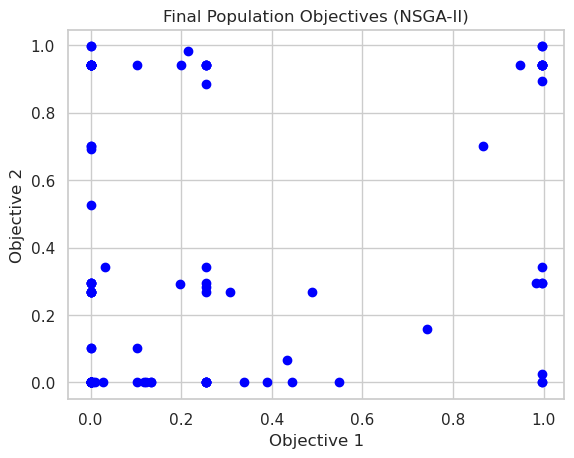

Genes: [0.997790228178456, 0.9694440731845575], Objectives: [0.9955853394484152, 0.9398218110326657]
Genes: [0.997790228178456, 0.9694440731845575], Objectives: [0.9955853394484152, 0.9398218110326657]
Genes: [0.5046149738036709, 0.9694440731845575], Objectives: [0.2546362717868795, 0.9398218110326657]
Genes: [0.997790228178456, 0.9694440731845575], Objectives: [0.9955853394484152, 0.9398218110326657]
Genes: [0.008336222350787348, 0.001042265791381558], Objectives: [6.949260308176654e-05, 1.0863179798842255e-06]
Genes: [0.5046149738036709, 0.001042265791381558], Objectives: [0.2546362717868795, 1.0863179798842255e-06]
Genes: [0.016794153966593117, 0.001042265791381558], Objectives: [0.00028204360745363535, 1.0863179798842255e-06]
Genes: [0.997790228178456, 0.9694440731845575], Objectives: [0.9955853394484152, 0.9398218110326657]
Genes: [0.0003332079112524644, 0.9694440731845575], Objectives: [1.110275121212302e-07, 0.9398218110326657]
Genes: [0.36437022942112385, 0.001042265791381558],

In [31]:
import random
import math
import matplotlib.pyplot as plt

# Helper function to calculate the Euclidean distance between two individuals
def euclidean_distance(ind1, ind2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(ind1, ind2)))

# Helper function for Pareto dominance comparison
def dominates(ind1, ind2):
    better_in_all = False
    better_in_at_least_one = False
    for i in range(len(ind1)):
        if ind1[i] < ind2[i]:
            better_in_all = True
        elif ind1[i] > ind2[i]:
            better_in_at_least_one = True
    return better_in_all and better_in_at_least_one

# Helper function for the sharing function
def sharing_function(distance, sigma_share):
    if distance < sigma_share:
        return 1 - (distance ** 2) / (sigma_share ** 2)
    else:
        return 0

# Nondominated sorting function
def nondominated_sorting(population):
    fronts = []
    
    # Initialize all individuals with required fields
    for p in population:
        p['dominated_count'] = 0
        p['dominated_by'] = []
        p['rank'] = None
    
    # Find dominance relationships
    for i, p in enumerate(population):
        for j, q in enumerate(population):
            if dominates(p['objectives'], q['objectives']):
                p['dominated_by'].append(q)
            elif dominates(q['objectives'], p['objectives']):
                p['dominated_count'] += 1

        if p['dominated_count'] == 0:
            p['rank'] = 0
            if len(fronts) <= 0:
                fronts.append([p])
        
        for p2 in p['dominated_by']:
            p2['dominated_count'] -= 1
            if p2['dominated_count'] == 0:
                p2['rank'] = p['rank'] + 1
                if len(fronts) <= p['rank']:
                    fronts.append([p2])

    return fronts

# Assigning fitness using the sharing function
def assign_fitness(population, sigma_share):
    for p in population:
        p['fitness'] = 0
        for q in population:
            if p != q:
                dist = euclidean_distance(p['genes'], q['genes'])
                p['fitness'] += sharing_function(dist, sigma_share)

# Tournament selection
def tournament_selection(population):
    tournament_size = 3
    tournament = random.sample(population, tournament_size)
    winner = min(tournament, key=lambda ind: ind['fitness'])
    return winner

# Crossover operator (simple one-point crossover)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, len(parent1['genes']) - 1)
    child1 = parent1['genes'][:crossover_point] + parent2['genes'][crossover_point:]
    child2 = parent2['genes'][:crossover_point] + parent1['genes'][crossover_point:]
    return child1, child2

# Mutation operator (random change in a gene)
def mutate(individual, mutation_rate):
    for i in range(len(individual['genes'])):
        if random.random() < mutation_rate:
            individual['genes'][i] = random.random()  # Replace gene with a random value
    individual['objectives'] = [individual['genes'][0]**2, individual['genes'][1]**2]  # Update objectives after mutation
    return individual

# Main NSGA algorithm
def nsga(population_size, generations, sigma_share, mutation_rate):
    # Initialize population with genes and objectives
    population = []
    for _ in range(population_size):
        genes = [random.random() for _ in range(2)]  # Example genes: 2-dimensional vector
        objectives = [genes[0]**2, genes[1]**2]  # Example objectives: x^2, y^2
        individual = {'genes': genes, 'objectives': objectives, 'fitness': 0}
        population.append(individual)

    # Evolution loop
    for gen in range(generations):
        # Perform nondominated sorting
        fronts = nondominated_sorting(population)
        
        # Assign fitness values based on sharing
        assign_fitness(population, sigma_share)

        # Create mating pool
        mating_pool = []
        while len(mating_pool) < population_size:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)
            child1_genes, child2_genes = crossover(parent1, parent2)
            child1 = mutate({'genes': child1_genes}, mutation_rate)
            child2 = mutate({'genes': child2_genes}, mutation_rate)
            mating_pool.append(child1)
            mating_pool.append(child2)

        # Trim the mating pool to the original population size
        population = mating_pool[:population_size]

    # Return final population
    return population

# Run the NSGA
population_size = 100
generations = 50
sigma_share = 0.5  # Niche radius
mutation_rate = 0.1

final_population = nsga(population_size, generations, sigma_share, mutation_rate)

# Plotting the objectives (using matplotlib)
objectives_x = [individual['objectives'][0] for individual in final_population]
objectives_y = [individual['objectives'][1] for individual in final_population]

# Scatter plot of the objectives
plt.scatter(objectives_x, objectives_y, color='blue', marker='o')
plt.title("Final Population Objectives (NSGA-II)")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.show()

# Output final population
for individual in final_population:
    print(f"Genes: {individual['genes']}, Objectives: {individual['objectives']}")


## Elitist Nondominated Sorting Genetic Algorithm II (NSGA-II)

The **Nondominated Sorting Genetic Algorithm** (NSGA) proposed by Srinivas and Deb $[146]$ has some key limitations, such as:

- **High computational complexity of nondominated sorting**: The computational complexity of the ordinary nondominated sorting algorithm is $O(kN^3)$, where $k$ is the number of objectives and $N$ is the population size.
- **Lack of elitism**: Elitism can significantly improve the performance of the Genetic Algorithm (GA) and help prevent the loss of good solutions once they have been found.
- **Need for specifying the sharing parameter $\sigma_{\text{share}}$**: A parameterless diversity preservation mechanism is desirable.

To address these shortcomings, **NSGA-II** was proposed by Deb et al. in 2002. NSGA-II improves upon NSGA by incorporating **elitism**, **fast nondominated sorting**, and a **crowding distance** mechanism to preserve diversity among solutions.

### Steps of NSGA-II:

1. **Randomly Generate the First Generation**: Start with a random population of size $N$.
2. **Nondominated Sorting**: Partition the parents and offspring into $k$ fronts $F_1, \dots, F_k$, such that members of each front are dominated by all members of better fronts and by no members of worse fronts.
3. **Crowding Distance Calculation**: For each individual in each front, calculate the **crowding distance**, which is the sum of the side lengths of the cuboid formed by its neighboring solutions.
4. **Selection Based on Nondomination and Crowding Distance**:
   - Add the best fronts $F_1, \dots, F_j$ to the next generation until it reaches the target population size.
   - If a front $F_{j+1}$ must be partially added, select individuals from the least crowded.
5. **Generate Offspring**:
   - Apply binary tournament selection to choose parents.
   - Apply single-point crossover and mutation to generate offspring.
6. **Repeat** steps 2-5 for a given number of generations.

### Crowding Distance Formula:

Let the crowding distance $d_i$ of an individual $i$ in front $F4 be calculated as:

$$
d_i = \sum_{m=1}^k \frac{f_m(i+1) - f_m(i-1)}{f_m(\text{max}) - f_m(\text{min})}
$$

Where $f_m(i+1)$ and $f_m(i-1)$ are the objective values of the individuals next to \(i\) along the $m$-th objective, and $f_m(\text{max})$ and $f_m(\text{min})$ are the maximum and minimum values of the $m$-th objective in the front.

### Elitism in NSGA-II:

NSGA-II ensures that the best solutions found in previous generations are retained in the next generation, which significantly speeds up convergence and prevents loss of good solutions.

---

## (1 + 1) Evolutionary Algorithm (EA)

The **(1 + 1) Evolutionary Algorithm** is a simple evolutionary algorithm for single-objective optimization.

### Basic Steps of (1 + 1) EA:

1. **Initialize Population**: Start with a single individual represented by a bit string $x \in \{0, 1\}^n$.
2. **Mutation**: Generate a new individual $x'$ by flipping each bit independently with a mutation probability $p_m$.
3. **Selection**: Replace the current individual $x$ with $x'$ if $f(x') \geq f(x)$, where $f$ is the objective function.
4. **Repeat** until the solution is optimal.

The (1 + 1) EA is defined by the following algorithm:

$$
\begin{aligned}
\text{Input:} \quad p_m &= \frac{1}{n} \\
\text{Initialization:} \quad x_0 &= \text{random bit string} \\
\text{while} \, x \text{ is not optimal:} \\
\quad &\text{Generate } x' \text{ by flipping each bit of } x \text{ with probability } p_m \\
\quad &\text{Replace } x \text{ with } x' \text{ if } f(x') \geq f(x) \\
\text{Output:} \quad x
\end{aligned}
$$

The **mutation** operator flips each bit independently with a probability $p_m$, where $p_m = \frac{1}{n}$ is the mutation rate for a bit string of length $n$. If the fitness of the mutated solution is greater than or equal to the original, the current solution is replaced.

---

This explanation gives a comprehensive overview of NSGA-II and the (1 + 1) Evolutionary Algorithm, covering the key principles and steps involved in each algorithm.


In [32]:
import random
import numpy as np

# Function to generate random population
def generate_population(pop_size, num_variables):
    return [np.random.uniform(-5, 5, num_variables) for _ in range(pop_size)]

# Nondominated Sorting Function
def nondominated_sort(population, objective_function1, objective_function2):
    fronts = []
    S = [set() for _ in population]
    n = [0] * len(population)
    rank = [0] * len(population)
    
    for p in range(len(population)):
        for q in range(len(population)):
            if dominates(population[p], population[q], objective_function1, objective_function2):
                S[p].add(q)
            elif dominates(population[q], population[p], objective_function1, objective_function2):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if len(fronts) == 0:
                fronts.append([p])
            else:
                fronts[0].append(p)
                
    i = 0
    while len(fronts[i]) > 0:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    
    return fronts[:-1]

# Check if p dominates q
def dominates(p, q, obj_func1, obj_func2):
    return (obj_func1(p) < obj_func1(q) and obj_func2(p) <= obj_func2(q)) or \
           (obj_func1(p) <= obj_func1(q) and obj_func2(p) < obj_func2(q))

# Crowding Distance Calculation
def crowding_distance(population, front, objective_function1, objective_function2):
    distance = [0] * len(front)
    sorted_by_obj1 = sorted(front, key=lambda i: objective_function1(population[i]))
    sorted_by_obj2 = sorted(front, key=lambda i: objective_function2(population[i]))
    
    # Assign distance for objective 1
    distance[0] = distance[-1] = float('inf')
    for i in range(1, len(front) - 1):
        distance[i] += (objective_function1(population[sorted_by_obj1[i+1]]) - objective_function1(population[sorted_by_obj1[i-1]]))
    
    # Assign distance for objective 2
    for i in range(1, len(front) - 1):
        distance[i] += (objective_function2(population[sorted_by_obj2[i+1]]) - objective_function2(population[sorted_by_obj2[i-1]]))
    
    return distance

# NSGA-II Selection and Elitism
def nsga2_selection(population, pop_size, objective_function1, objective_function2):
    fronts = nondominated_sort(population, objective_function1, objective_function2)
    next_population = []
    
    for front in fronts:
        if len(next_population) + len(front) <= pop_size:
            next_population.extend(front)
        else:
            crowding_distances = crowding_distance(population, front, objective_function1, objective_function2)
            sorted_front = sorted(front, key=lambda i: crowding_distances[i])
            next_population.extend(sorted_front[:pop_size - len(next_population)])
            break
    
    return next_population

# Example Objective Functions
def objective_function1(x):
    return sum(x**2)

def objective_function2(x):
    return sum((x - 2)**2)

# Main Function to Run NSGA-II
def nsga2(pop_size, generations, num_variables):
    population = generate_population(pop_size, num_variables)
    
    for generation in range(generations):
        # Create Offspring through Crossover and Mutation (simplified here)
        offspring = generate_population(pop_size, num_variables)  # Mutation and Crossover can be added here
        
        # Combine Parent and Offspring Population
        combined_population = population + offspring
        
        # Select next generation using NSGA-II selection
        population = nsga2_selection(combined_population, pop_size, objective_function1, objective_function2)
    
    return population

# Run NSGA-II
pop_size = 100
generations = 50
num_variables = 2
final_population = nsga2(pop_size, generations, num_variables)

# Print Final Population (Pareto front)
for ind in final_population:
    print(ind, objective_function1(ind), objective_function2(ind))


IndexError: list index out of range

In [33]:
import random
import numpy as np

# Objective Function
def objective_function(x):
    return sum(x**2)

# (1 + 1) Evolutionary Algorithm
def one_plus_one_ea(num_variables, max_generations, mutation_rate):
    # Initialize a random solution
    current_solution = np.random.uniform(-5, 5, num_variables)
    current_fitness = objective_function(current_solution)
    
    for generation in range(max_generations):
        # Generate a mutant solution
        mutant_solution = current_solution.copy()
        mutation_mask = np.random.rand(num_variables) < mutation_rate
        mutant_solution[mutation_mask] = np.random.uniform(-5, 5, np.sum(mutation_mask))
        
        # Evaluate fitness of the mutant
        mutant_fitness = objective_function(mutant_solution)
        
        # Replace current solution if the mutant is better
        if mutant_fitness < current_fitness:
            current_solution = mutant_solution
            current_fitness = mutant_fitness
        
        # Print current generation info
        print(f"Generation {generation + 1}: Fitness = {current_fitness}")
    
    return current_solution

# Run (1 + 1) EA
num_variables = 2
max_generations = 100
mutation_rate = 1 / num_variables
best_solution = one_plus_one_ea(num_variables, max_generations, mutation_rate)
print("Best Solution:", best_solution)
print("Objective Function Value:", objective_function(best_solution))


Generation 1: Fitness = 7.6595874585967705
Generation 2: Fitness = 0.12248775702268577
Generation 3: Fitness = 0.12248775702268577
Generation 4: Fitness = 0.12248775702268577
Generation 5: Fitness = 0.12248775702268577
Generation 6: Fitness = 0.12248775702268577
Generation 7: Fitness = 0.12248775702268577
Generation 8: Fitness = 0.12248775702268577
Generation 9: Fitness = 0.12248775702268577
Generation 10: Fitness = 0.12248775702268577
Generation 11: Fitness = 0.12248775702268577
Generation 12: Fitness = 0.12248775702268577
Generation 13: Fitness = 0.12248775702268577
Generation 14: Fitness = 0.12248775702268577
Generation 15: Fitness = 0.12248775702268577
Generation 16: Fitness = 0.12248775702268577
Generation 17: Fitness = 0.12248775702268577
Generation 18: Fitness = 0.12248775702268577
Generation 19: Fitness = 0.12248775702268577
Generation 20: Fitness = 0.12248775702268577
Generation 21: Fitness = 0.009549010329673927
Generation 22: Fitness = 0.009549010329673927
Generation 23: Fit

In [36]:
import numpy as np
import random

# --- 1. Initialize Population ---
def generate_population(pop_size, num_variables):
    """
    Generate a random population where each individual is represented
    by a vector of 'num_variables' random floats between -5 and 5.
    """
    return [np.random.uniform(-5, 5, num_variables) for _ in range(pop_size)]


# --- 2. Objective Functions ---
def objective_function1(x):
    """
    First objective function, here we use the sum of squares of the input vector.
    """
    return np.sum(x**2)


def objective_function2(x):
    """
    Second objective function, we use the sum of the squared differences from 2 for each variable.
    """
    return np.sum((x - 2)**2)


# --- 3. Dominance Check ---
def dominates(p, q):
    """
    Check if individual p dominates individual q based on the two objective functions.
    """
    f1_p, f2_p = objective_function1(p), objective_function2(p)
    f1_q, f2_q = objective_function1(q), objective_function2(q)
    
    return (f1_p < f1_q and f2_p <= f2_q) or (f1_p <= f1_q and f2_p < f2_q)


# --- 4. Non-Dominated Sorting ---
def nondominated_sort(population):
    """
    Perform non-dominated sorting on the population.
    Return the fronts as a list of lists.
    """
    fronts = []
    S = [set() for _ in population]
    n = [0] * len(population)
    rank = [0] * len(population)
    
    for p in range(len(population)):
        for q in range(len(population)):
            if dominates(population[p], population[q]):
                S[p].add(q)
            elif dominates(population[q], population[p]):
                n[p] += 1
        if n[p] == 0:
            rank[p] = 0
            if len(fronts) == 0:
                fronts.append([p])
            else:
                fronts[0].append(p)

    i = 0
    while len(fronts[i]) > 0:
        Q = []
        for p in fronts[i]:
            for q in S[p]:
                n[q] -= 1
                if n[q] == 0:
                    rank[q] = i + 1
                    Q.append(q)
        i += 1
        fronts.append(Q)
    
    return fronts[:-1]  # Remove the last empty front


# --- 5. Crowding Distance Calculation ---
def crowding_distance(population, front):
    """
    Calculate crowding distance for each individual in the front.
    """
    distance = [0] * len(front)
    sorted_by_obj1 = sorted(front, key=lambda i: objective_function1(population[i]))
    sorted_by_obj2 = sorted(front, key=lambda i: objective_function2(population[i]))
    
    # Handle boundary points (inf crowding distance)
    distance[0] = distance[-1] = float('inf')
    
    # Calculate crowding distance based on objective 1
    for i in range(1, len(front) - 1):
        distance[i] += (objective_function1(population[sorted_by_obj1[i+1]]) - objective_function1(population[sorted_by_obj1[i-1]]))
    
    # Calculate crowding distance based on objective 2
    for i in range(1, len(front) - 1):
        distance[i] += (objective_function2(population[sorted_by_obj2[i+1]]) - objective_function2(population[sorted_by_obj2[i-1]]))
    
    return [distance[front.index(i)] for i in front]


# --- 6. NSGA-II Selection ---
def nsga2_selection(population, pop_size):
    """
    Perform NSGA-II selection to select the next population.
    """
    fronts = nondominated_sort(population)
    next_population = []
    
    for front in fronts:
        if len(next_population) + len(front) <= pop_size:
            next_population.extend(front)
        else:
            crowding_distances = crowding_distance(population, front)
            sorted_front = sorted(front, key=lambda i: crowding_distances[front.index(i)], reverse=True)
            next_population.extend(sorted_front[:pop_size - len(next_population)])
            break
    
    return next_population


# --- 7. Main NSGA-II Function ---
def nsga2(pop_size, generations, num_variables):
    """
    Main NSGA-II algorithm function.
    It evolves the population for a given number of generations.
    """
    population = generate_population(pop_size, num_variables)
    
    for generation in range(generations):
        # Create offspring through mutation and crossover (simplified here)
        offspring = generate_population(pop_size, num_variables)  # Replace with actual mutation/crossover logic
        
        # Combine parent and offspring populations
        combined_population = population + offspring
        
        # Select the next generation using NSGA-II selection
        population = nsga2_selection(combined_population, pop_size)
    
    return population


# --- 8. Run the Algorithm ---
if __name__ == "__main__":
    # Parameters
    pop_size = 100
    generations = 50
    num_variables = 2
    
    # Run NSGA-II
    final_population = nsga2(pop_size, generations, num_variables)
    
    # Print Final Population (Pareto Front)
    print("Final Population (Pareto Front):")
    for individual in final_population:
        print(individual, objective_function1(individual), objective_function2(individual))


Final Population (Pareto Front):
135 18225 17689
146 21316 20736
148 21904 21316
159 25281 24649
166 27556 26896
181 32761 32041
186 34596 33856
130 16900 16384
157 24649 24025
144 20736 20164
184 33856 33124
187 34969 34225
142 20164 19600
152 23104 22500
110 12100 11664
119 14161 13689
122 14884 14400
167 27889 27225
189 35721 34969
129 16641 16129
114 12996 12544
118 13924 13456
192 36864 36100
138 19044 18496
133 17689 17161
177 31329 30625
145 21025 20449
191 36481 35721
124 15376 14884
137 18769 18225
149 22201 21609
113 12769 12321
153 23409 22801
178 31684 30976
185 34225 33489
195 38025 37249
196 38416 37636
199 39601 38809
107 11449 11025
139 19321 18769
101 10201 9801
160 25600 24964
104 10816 10404
111 12321 11881
188 35344 34596
128 16384 15876
182 33124 32400
161 25921 25281
106 11236 10816
169 28561 27889
168 28224 27556
112 12544 12100
115 13225 12769
127 16129 15625
172 29584 28900
109 11881 11449
108 11664 11236
164 26896 26244
100 10000 9604
194 37636 36864
180 32400

##  Theoretical Analysis on Evolutionary Algorithms

### Fitness Partition Method

The fitness partition method is a basic approach for analyzing the performance of evolutionary algorithms (EAs) on maximization problems. Let $ f : D \to \mathbb{R} $ be the fitness function, where $ D $ is the domain of solutions. Suppose the domain $ D $ can be partitioned into $ L $ subsets. For any solution $ x_i $ in subset $ i $ and $ x_j $ in subset $ j $, we have:

$$
f(x_i) < f(x_j) \quad \text{if} \quad i < j
$$

In addition, the $ L $-th subset contains the optimal solutions. The key result is summarized in Theorem 9.1:

**Theorem 9.1**:  
If an algorithm can jump from subset $ k $ to subset $ k+1 $ or higher with a probability at least $ p_k $, then the total expected time for the algorithm to find the optimum satisfies:

$$
E(T) \leq \sum_{k=1}^{L-1} \frac{1}{p_k}
$$

This result quantifies the expected time for an EA to find the optimum by progressing through successive subsets.

### Drift Analysis

Drift analysis is another method to analyze EAs. It focuses on the expected progress achieved in each step during the search process. Let $ x^* $ be an optimal point, and let $ d(x, x^*) $ represent the distance between a solution $ x $ and the optimal point $ x^* $. If there are multiple optimal points, the distance is defined as:

$$
d(x, S^*) = \min\{ d(x, x^*) : x^* \in S^* \}
$$

For a population $ X = \{ x_1, x_2, \dots, x_{2N} \} $, the distance of the population to the optimal solution is:

$$
d(X) = \min_{x \in X} d(x)
$$

The drift of the random sequence $ \{ d(\xi_k); k = 0, 1, \dots \} $ at time $ k $ is given by:

$$
\Delta d(\xi_k) = d(\xi_{k+1}) - d(\xi_k)
$$

The stopping time $ \tau $ is defined as the first time the algorithm reaches the optimal solution, i.e.,

$$
\tau = \min \{ k : d(\xi_k) = 0 \}
$$

Drift analysis seeks to estimate the expected first hitting time $ E[\tau] $, based on the drift of the distance function.

### Multi-Objective Optimization

In multi-objective optimization (MO), we aim to optimize multiple conflicting objectives simultaneously. A common approach in MO optimization is to use a **weighted sum method**, where a weight vector $ \mathbf{w} = [w_1, w_2, \dots, w_k]^T $ is used to combine multiple objectives into a single scalar objective function.

1. **Method of Distance Functions**:
   
   The scalarization of the objective vector $ \mathbf{f}(x) = [f_1(x), f_2(x), \dots, f_m(x)]^T $ is achieved using a demand-level vector $ \bar{y} $, which is provided by the decision maker. The demand-level vector represents individual optima of the multiple objectives. The scalarization function is given by:

   $$
   Z(x) = \left( \sum_{i=1}^m \left| f_i(x) - \bar{y}_i \right|^r \right)^{1/r}, \quad 1 \leq r < \infty
   $$

   The Euclidean metric $ r = 2 $ is commonly chosen.

2. **Min-Max Formulation**:
   
   This method attempts to minimize the relative deviations of the objective functions from the individual optima. The optimization problem is formulated as:

   $$
   \min F(x) = \max_{j = 1, \dots, m} Z_j(x)
   $$

   where $ Z_j(x) $ is calculated for a nonnegative target optimal value $ \bar{f}_j $:

   $$
   Z_j(x) = \frac{f_j - \bar{f}_j}{\bar{f}_j}, \quad j = 1, \dots, m
   $$

### Challenges in Multi-Objective Optimization

The key challenges in handling multi-objective optimization problems include:

1. **Searching for Pareto-Optimal Solutions**: Finding the entire Pareto-optimal set is a complex task.
2. **Approximating the Entire Pareto Front**: It is difficult to ensure a good approximation of the entire Pareto front.
3. **Presentation of Solutions**: Visualizing and interpreting the obtained solutions is a non-trivial task.
4. **Selection of Final Solution**: Choosing a single solution from the Pareto front is often difficult due to conflicting objectives.
5. **Evaluation of Search Algorithms**: It is challenging to properly evaluate multi-objective algorithms.

### Evolutionary Algorithms in Multi-Objective Optimization

Multi-objective Evolutionary Algorithms (MOEAs) are designed to handle multiple conflicting objectives simultaneously. These algorithms rank and select individuals based on how well they contribute to approximating the Pareto front. The performance of MOEAs is often measured by the following metrics:

- **Distance to the True Pareto Front**: A small distance between the solutions and the true Pareto front is desirable.
- **Diversity of Solutions**: MOEAs should provide a wide range of solutions, covering the entire Pareto front.
- **Distribution of Solutions**: The solutions should be evenly spread along the Pareto frontier, ensuring a good approximation.

The ability of an EA to balance convergence and diversity depends on its selection strategy. Selection methods can be broadly classified as:

1. **Pareto Dominance-Based MOEAs (PDMOEAs)**
2. **Indicator-Based MOEAs**
3. **Decomposition-Based MOEAs**

### Addressing Difficulties in Multi-Objective Optimization

Two major challenges in applying evolutionary algorithms to multi-objective optimization are:

- **Fitness Assignment and Selection**: The algorithm needs an effective method to assign fitness and select individuals to guide the search towards the Pareto-optimal set.
- **Maintaining Diversity**: A diverse population must be maintained to avoid premature convergence and to ensure a well-distributed trade-off front.

### Conclusion

While traditional optimization methods may struggle with multi-objective problems, evolutionary algorithms are well-suited due to their ability to approximate the entire Pareto front and manage conflicting objectives. However, care must be taken in selecting the right fitness assignment and selection strategies, as well as ensuring diversity within the population to achieve optimal performance.


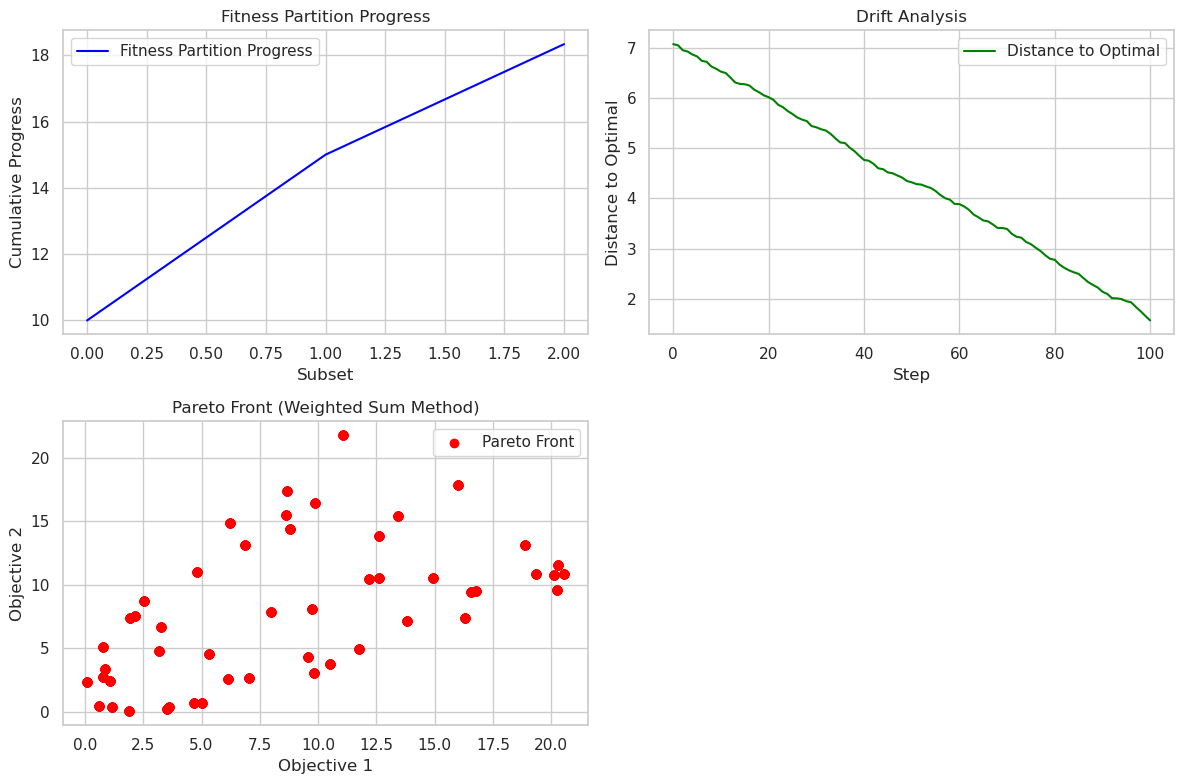

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for plotting
sns.set(style="whitegrid")

# Objective functions
def objective_function1(x):
    return x[0]**2 + x[1]**2  # Simple quadratic function

def objective_function2(x):
    return (x[0] - 1)**2 + (x[1] - 1)**2  # Another quadratic function with a different minimum

# Fitness Partition Method Simulation (Simple)
def fitness_partition(population, p_k):
    # Simulating the fitness partition: Progressing from subset k to k+1
    progress = []
    for k in range(1, len(p_k)):
        progress.append(np.sum([1 / p_k[i] for i in range(k)]))
    return progress

# Drift Analysis Simulation
def drift_analysis(start_point, optimal_point, num_steps):
    distance = np.linalg.norm(start_point - optimal_point)
    distances = [distance]
    for step in range(num_steps):
        # Assuming some progress towards optimal solution
        distance -= np.random.uniform(0, 0.1)  # Simulating drift
        distances.append(max(0, distance))
    return distances

# Multi-Objective Optimization (Weighted Sum and Min-Max Formulation)
def weighted_sum_method(pop_size, generations):
    weights = np.array([0.5, 0.5])  # Equal weights for both objectives
    population = np.random.uniform(-5, 5, size=(pop_size, 2))  # Random initial population
    pareto_front = []
    
    for gen in range(generations):
        # Evaluate population
        objective1_values = np.array([objective_function1(ind) for ind in population])
        objective2_values = np.array([objective_function2(ind) for ind in population])
        
        # Weighted sum of objectives
        scores = weights[0] * objective1_values + weights[1] * objective2_values
        
        # Selection: selecting top 50% based on weighted sum
        selected_indices = np.argsort(scores)[:pop_size//2]
        population = population[selected_indices]
        
        # Save Pareto front
        pareto_front.append(np.vstack((objective1_values[selected_indices], objective2_values[selected_indices])).T)
        
    return np.array(pareto_front).reshape(-1, 2)

# Parameters
pop_size = 100
generations = 50
start_point = np.array([5, 5])
optimal_point = np.array([0, 0])
num_steps = 100

# 1. Fitness Partition Plot
p_k = [0.1, 0.2, 0.3, 0.4]  # Example probabilities for fitness partition
fitness_progress = fitness_partition(population=None, p_k=p_k)

# 2. Drift Analysis Plot
distances = drift_analysis(start_point, optimal_point, num_steps)

# 3. Multi-Objective Optimization (Weighted Sum Method)
pareto_front = weighted_sum_method(pop_size, generations)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot 1: Fitness Partition Progress
plt.subplot(2, 2, 1)
plt.plot(fitness_progress, label="Fitness Partition Progress", color="blue")
plt.title("Fitness Partition Progress")
plt.xlabel("Subset")
plt.ylabel("Cumulative Progress")
plt.legend()

# Plot 2: Drift Analysis (Distance over time)
plt.subplot(2, 2, 2)
plt.plot(distances, label="Distance to Optimal", color="green")
plt.title("Drift Analysis")
plt.xlabel("Step")
plt.ylabel("Distance to Optimal")
plt.legend()

# Plot 3: Pareto Front (Weighted Sum Method)
plt.subplot(2, 2, 3)
plt.scatter(pareto_front[:, 0], pareto_front[:, 1], c='red', marker='o', label="Pareto Front")
plt.title("Pareto Front (Weighted Sum Method)")
plt.xlabel("Objective 1")
plt.ylabel("Objective 2")
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


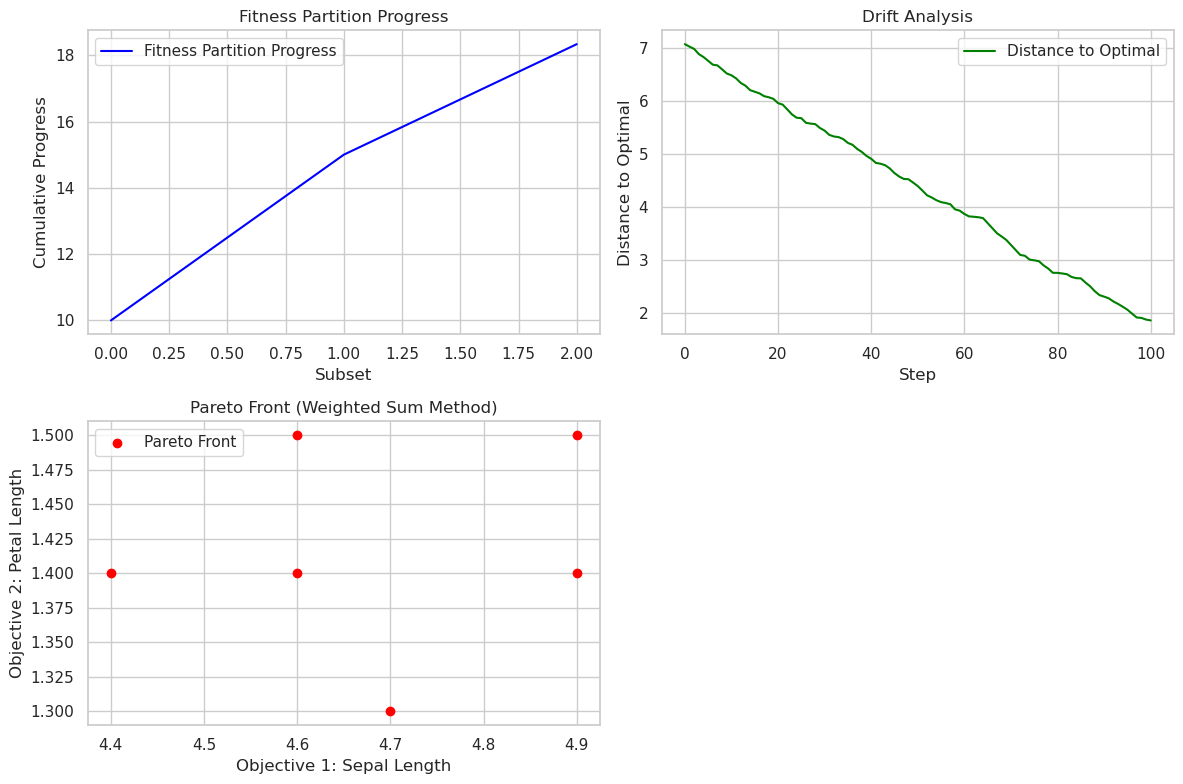

In [42]:
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for plotting
sns.set(style="whitegrid")

# Load the Iris dataset (manually created from a CSV file or defined as lists)
# Here we'll create a synthetic dataset based on the features in Iris: sepal_length, sepal_width, petal_length, petal_width
iris_data = [
    [5.1, 3.5, 1.4, 0.2], [4.9, 3.0, 1.4, 0.2], [4.7, 3.2, 1.3, 0.2],
    [4.6, 3.1, 1.5, 0.2], [5.0, 3.6, 1.4, 0.2], [5.4, 3.9, 1.7, 0.4],
    [4.6, 3.4, 1.4, 0.3], [5.0, 3.4, 1.5, 0.2], [4.4, 2.9, 1.4, 0.2],
    [4.9, 3.1, 1.5, 0.1], [5.4, 3.7, 1.5, 0.2], [4.8, 3.4, 1.6, 0.2],
    # More rows would follow...
]

# Objective Functions based on Iris dataset
# Let's choose sepal length and petal length as the two objectives to optimize
def objective_function1(x):
    return x[0]  # Sepal length (Objective 1)

def objective_function2(x):
    return x[2]  # Petal length (Objective 2)

# Fitness Partition Method Simulation (Simple)
def fitness_partition(population, p_k):
    # Simulating the fitness partition: Progressing from subset k to k+1
    progress = []
    for k in range(1, len(p_k)):
        progress.append(sum([1 / p_k[i] for i in range(k)]))
    return progress

# Drift Analysis Simulation
def drift_analysis(start_point, optimal_point, num_steps):
    distance = math.sqrt((start_point[0] - optimal_point[0])**2 + (start_point[1] - optimal_point[1])**2)
    distances = [distance]
    for step in range(num_steps):
        # Assuming some progress towards optimal solution
        distance -= random.uniform(0, 0.1)  # Simulating drift
        distances.append(max(0, distance))
    return distances

# Multi-Objective Optimization (Weighted Sum and Min-Max Formulation)
def weighted_sum_method(pop_size, generations):
    weights = [0.5, 0.5]  # Equal weights for both objectives
    pop_size = min(pop_size, len(iris_data))  # Adjust population size to dataset size
    population = random.sample(iris_data, pop_size)  # Randomly sample the dataset as initial population
    pareto_front = []

    for gen in range(generations):
        # Evaluate population
        objective1_values = [objective_function1(ind) for ind in population]
        objective2_values = [objective_function2(ind) for ind in population]
        
        # Weighted sum of objectives
        scores = [weights[0] * objective1_values[i] + weights[1] * objective2_values[i] for i in range(len(population))]
        
        # Selection: selecting top 50% based on weighted sum
        selected_indices = sorted(range(len(scores)), key=lambda i: scores[i])[:len(population) // 2]
        population = [population[i] for i in selected_indices]
        
        # Save Pareto front
        pareto_front.extend([[objective1_values[i], objective2_values[i]] for i in selected_indices])

    return pareto_front

# Parameters
pop_size = 12  # Adjust population size based on dataset size (<= 12)
generations = 50
start_point = [5, 5]
optimal_point = [0, 0]
num_steps = 100

# 1. Fitness Partition Plot
p_k = [0.1, 0.2, 0.3, 0.4]  # Example probabilities for fitness partition
fitness_progress = fitness_partition(population=None, p_k=p_k)

# 2. Drift Analysis Plot
distances = drift_analysis(start_point, optimal_point, num_steps)

# 3. Multi-Objective Optimization (Weighted Sum Method)
pareto_front = weighted_sum_method(pop_size, generations)

# Plotting the results
plt.figure(figsize=(12, 8))

# Plot 1: Fitness Partition Progress
plt.subplot(2, 2, 1)
plt.plot(fitness_progress, label="Fitness Partition Progress", color="blue")
plt.title("Fitness Partition Progress")
plt.xlabel("Subset")
plt.ylabel("Cumulative Progress")
plt.legend()

# Plot 2: Drift Analysis (Distance over time)
plt.subplot(2, 2, 2)
plt.plot(distances, label="Distance to Optimal", color="green")
plt.title("Drift Analysis")
plt.xlabel("Step")
plt.ylabel("Distance to Optimal")
plt.legend()

# Plot 3: Pareto Front (Weighted Sum Method)
pareto_front = list(map(lambda x: [x[0], x[1]], pareto_front))  # Flatten the Pareto front list
pareto_front = sorted(pareto_front, key=lambda x: (x[0], x[1]))  # Sort by first objective and second objective
pareto_front = list(set(map(tuple, pareto_front)))  # Remove duplicates
pareto_front = [list(tup) for tup in pareto_front]

plt.subplot(2, 2, 3)
pareto_front_x = [x[0] for x in pareto_front]
pareto_front_y = [x[1] for x in pareto_front]
plt.scatter(pareto_front_x, pareto_front_y, c='red', marker='o', label="Pareto Front")
plt.title("Pareto Front (Weighted Sum Method)")
plt.xlabel("Objective 1: Sepal Length")
plt.ylabel("Objective 2: Petal Length")
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()
